# Imports and Global Functions

In [51]:
import random

from enum import Enum

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

from sklearn.utils import shuffle
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, normalize, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import KernelPCA

from lazypredict.Supervised import LazyRegressor

import pickle

from itertools import product


def printRegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    print("The mse is: ", mean_squared_error(truth, preds, squared=False))
    corr, pval = pearsonr(truth, preds)
    print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))
    print("The Maximum Error is is: ", max_error(truth, preds))
    print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    
def one_hot_encode_categorical_features(all_features: pd.DataFrame) -> pd.DataFrame:
    is_categorical = lambda f: all_features[f].apply(lambda x: not isinstance(x, float) or x.is_integer()).all()
    categorical_cols = [f for f in all_features if is_categorical(f)]
    other_cols = [f for f in all_features if not is_categorical(f)]
    
    encoder = OneHotEncoder(handle_unknown="ignore")
    categorical_matrix = all_features[categorical_cols].to_numpy().astype(int).astype(str)
    categorical_encoded_matrix = encoder.fit_transform(categorical_matrix).toarray()
    
    headers = []
    for base_name, categories in zip(categorical_cols, encoder.categories_):
        for c in categories:
            headers.append(base_name + "_" + c)
        # print(f"{base_name} has {len(categories)} categories")
    
    return pd.concat([all_features[other_cols], pd.DataFrame(data=categorical_encoded_matrix, columns=headers)], axis=1)

def is_float(element: any) -> bool:
    #If you expect None to be passed:
    if element is None: 
        return False
    try:
        float(element)
        return True
    except ValueError:
        return False

from threading import Lock, Thread

class SupportedModelType(Enum):

    LINEAR_REGRESSION=0
    SVR=1
    RANDOM_FOREST_REGRESSOR=2
    EXTRA_TREES_REGRESSOR=3


class CustomSVR():

    __predictive_function_lock__: Lock = Lock()
    __prediction_array_lock__: Lock = Lock()
    __prediction_array__: np.array = np.array([])

    __country_population_model__: SVR
    __fertility_rate_model__: SVR
    __life_expectancy_model__: SVR


    def __init__(self,
                    kernel: str = "rbf",
                    degree: int = 3,
                    gamma: str = "scale",
                    coef0: float = 0,
                    tol: float = 0.001,
                    C: float = 1,
                    epsilon: float = 0.1,
                    shrinking: bool = True,
                    cache_size: int = 200,
                    verbose: bool = False,
                    max_iter: int = -1
                ):

        self.__country_population_model__ = SVR(
            kernel=kernel,
            degree=degree,
            gamma=gamma,
            coef0=coef0,
            tol=tol,
            C=C,
            epsilon=epsilon,
            shrinking=shrinking,
            cache_size=cache_size,
            verbose=verbose,
            max_iter=max_iter
        )

        self.__fertility_rate_model__ = SVR(
            kernel=kernel,
            degree=degree,
            gamma=gamma,
            coef0=coef0,
            tol=tol,
            C=C,
            epsilon=epsilon,
            shrinking=shrinking,
            cache_size=cache_size,
            verbose=verbose,
            max_iter=max_iter
        )

        self.__life_expectancy_model__ = SVR(
            kernel=kernel,
            degree=degree,
            gamma=gamma,
            coef0=coef0,
            tol=tol,
            C=C,
            epsilon=epsilon,
            shrinking=shrinking,
            cache_size=cache_size,
            verbose=verbose,
            max_iter=max_iter
        )
    
    def fit(self, x, y):
        
        self.__country_population_model__.fit(x,y[:,0])
        self.__fertility_rate_model__.fit(x,y[:,1])
        self.__life_expectancy_model__.fit(x,y[:,2])
        #t_cp = Thread(target=self.__country_population_model__.fit, args=(x,y[:,0]))
        #t_cp.start()
        #t_fr = Thread(target=self.__fertility_rate_model__.fit, args=(x,y[:,1]))
        #t_fr.start()
        #t_le = Thread(target=self.__life_expectancy_model__.fit, args=(x,y[:,2]))
        #t_le.start()

        #t_cp.join()
        #t_fr.join()
        #t_le.join()


    def predict(self, x):

        self.__predictive_function_lock__.acquire()
        
        t_cp = Thread(target=self.__country_population_predict__, args=(x))
        t_cp.start()
        t_fr = Thread(target=self.__fertility_rate_predict__, args=(x))
        t_fr.start()
        t_le = Thread(target=self.__life_expectancy_predict__, args=(x))
        t_le.start()

        t_cp.join()
        t_fr.join()
        t_le.join()

        self.__predictive_function_lock__.release()
        return np.array(self.__prediction_array__)



    def __country_population_predict__(self,x):

        pred_cp = self.__country_population_model__.predict(x)

        self.__prediction_array_lock__.acquire()
        self.__prediction_array__[0] = pred_cp[0]
        self.__prediction_array_lock__.release()

    def __fertility_rate_predict__(self,x):

        pred_fr = self.__fertility_rate_model__.predict(x)

        self.__prediction_array_lock__.acquire()
        self.__prediction_array__[1] = pred_fr[0]
        self.__prediction_array_lock__.release()

    def __life_expectancy_predict__(self,x):

        pred_le = self.__life_expectancy_model__.predict(x)

        self.__prediction_array_lock__.acquire()
        self.__prediction_array__[2] = pred_le[0]
        self.__prediction_array_lock__.release()
        



def kfold_val(model_type: SupportedModelType, target_metrics: list, X_raw_train_df: pd.DataFrame, X_raw_test_df: pd.DataFrame, Y_delta_df: pd.DataFrame, Y_raw_df: pd.DataFrame, hyper_parameters):

    assert "RVE" in target_metrics or "mse" in target_metrics or "CorrelationScore" in target_metrics or "MaximumError" in target_metrics or "MeanAbsoluteError" in target_metrics

    assert len(target_metrics) == 1 and target_metrics[0] == "mse" # Not implemented fitness evaluation

    train_len = len(X_raw_train_df)
    test_len = len(X_raw_test_df)

    total_len = train_len + test_len

    X_raw_dataset = pd.concat([X_raw_train_df,X_raw_test_df], axis=0)

    assert len(X_raw_dataset) == len(Y_delta_df) == len(Y_raw_df)

    best_model = None
    best_hyperparams = None
    best_hyperparams_possib = []
    best_score = 99999999999999999999999.0

    for p in hyper_parameters:

        if model_type == SupportedModelType.LINEAR_REGRESSION:
            fit_intercept,\
                normalize,\
                copy_X,\
                n_jobs,\
                positive = p

        elif model_type == SupportedModelType.SVR:
            kernel,\
                degree,\
                gamma,\
                coef0,\
                tol,\
                C,\
                epsilon,\
                shrinking,\
                cache_size,\
                verbose,\
                max_iter = p

        elif model_type == SupportedModelType.RANDOM_FOREST_REGRESSOR:
            n_estimators,\
                criterion,\
                max_depth,\
                min_samples_split,\
                min_samples_leaf,\
                min_weight_fraction_leaf,\
                max_features,\
                max_leaf_nodes,\
                min_impurity_decrease,\
                bootstrap,\
                oob_score,\
                n_jobs,\
                random_state,\
                verbose,\
                warm_start,\
                ccp_alpha,\
                max_samples = p
        
        elif model_type == SupportedModelType.EXTRA_TREES_REGRESSOR:
            n_estimators,\
                criterion,\
                max_depth,\
                min_samples_split,\
                min_samples_leaf,\
                min_weight_fraction_leaf,\
                max_features,\
                max_leaf_nodes,\
                min_impurity_decrease,\
                bootstrap,\
                oob_score,\
                n_jobs,\
                random_state,\
                verbose,\
                warm_start,\
                ccp_alpha,\
                max_samples = p

        else:
            raise NotImplementedError()

        ix_test_start = 0
        score = 0
        n_iter = 0
        for ix_test_end in range(test_len,total_len,test_len):

            n_iter+=1

            X_train_df = pd.concat([X_raw_dataset[0:ix_test_start],X_raw_dataset[ix_test_end:]], axis=0)
            X_test_df = X_raw_dataset[ix_test_start:ix_test_end]
            X_test_np = X_test_df.to_numpy()

            Y_delta_train_df = pd.concat([Y_delta_df[0:ix_test_start],Y_delta_df[ix_test_end:]], axis=0)
            Y_raw_test_df = Y_raw_df[ix_test_start:ix_test_end]


            if model_type == SupportedModelType.LINEAR_REGRESSION:
                
                model = LinearRegression(
                        fit_intercept=fit_intercept,
                        normalize=normalize,
                        copy_X=copy_X,
                        n_jobs=n_jobs,
                        positive=positive
                    )
                
                model.fit(X_train_df.to_numpy(), Y_delta_train_df.to_numpy())

                truth = Y_raw_test_df.to_numpy()

                predicted_total=[]
                preds=[]
                curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
                curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
                curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
                for x in X_test_np:
                    y = model.predict(x.reshape(1, -1))[0]
                    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
                    preds.append(y)
                    predicted_total.append(y[0] * y[1] * y[2])
                predicted=np.array(preds)
                predicted_total=np.array(predicted_total)

                truth_total = [ t[0] * t[1] * t[2] for t in truth ]
                truth_total = np.array(truth_total)

                mse = mean_squared_error(truth_total, predicted_total)
                score += mse

            elif model_type == SupportedModelType.SVR:
                
                model = CustomSVR(
                        kernel=kernel,
                        degree=degree,
                        gamma=gamma,
                        coef0=coef0,
                        tol=tol,
                        C=C,
                        epsilon=epsilon,
                        shrinking=shrinking,
                        cache_size=cache_size,
                        verbose=verbose,
                        max_iter=max_iter
                    )
                
                model.fit(X_train_df.to_numpy(), Y_delta_train_df.to_numpy())

                truth = Y_raw_test_df.to_numpy()

                predicted_total=[]
                preds=[]
                curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
                curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
                curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
                for x in X_test_np:
                    y = model.predict(x.reshape(1, -1))
                    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
                    preds.append(y)
                    predicted_total.append(y[0] * y[1] * y[2])
                predicted=np.array(preds)
                predicted_total=np.array(predicted_total)

                truth_total = [ t[0] * t[1] * t[2] for t in truth ]
                truth_total = np.array(truth_total)

                mse = mean_squared_error(truth_total, predicted_total)
                score += mse

            elif model_type == SupportedModelType.RANDOM_FOREST_REGRESSOR:
                
                model = RandomForestRegressor(
                        n_estimators=n_estimators,
                        criterion=criterion,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        min_weight_fraction_leaf=min_weight_fraction_leaf,
                        max_features=max_features,
                        max_leaf_nodes=max_leaf_nodes,
                        min_impurity_decrease=min_impurity_decrease,
                        bootstrap=bootstrap,
                        oob_score=oob_score,
                        n_jobs=n_jobs,
                        random_state=random_state,
                        verbose=verbose,
                        warm_start=warm_start,
                        ccp_alpha=ccp_alpha,
                        max_samples=max_samples
                    )
                
                model.fit(X_train_df.to_numpy(), Y_delta_train_df.to_numpy())

                truth = Y_raw_test_df.to_numpy()

                preds=[]
                predicted_total=[]
                curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
                curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
                curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
                for x in X_test_np:
                    y = model.predict(x.reshape(1, -1))[0]
                    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
                    preds.append(y)
                    predicted_total.append(y[0] * y[1] * y[2])
                predicted=np.array(preds)
                predicted_total=np.array(predicted_total)

                truth_total = [ t[0] * t[1] * t[2] for t in truth ]
                truth_total = np.array(truth_total)

                mse = mean_squared_error(truth_total, predicted_total)
                score += mse

            elif model_type == SupportedModelType.EXTRA_TREES_REGRESSOR:
                
                model = ExtraTreesRegressor(
                        n_estimators=n_estimators,
                        criterion=criterion,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        min_weight_fraction_leaf=min_weight_fraction_leaf,
                        max_features=max_features,
                        max_leaf_nodes=max_leaf_nodes,
                        min_impurity_decrease=min_impurity_decrease,
                        bootstrap=bootstrap,
                        oob_score=oob_score,
                        n_jobs=n_jobs,
                        random_state=random_state,
                        verbose=verbose,
                        warm_start=warm_start,
                        ccp_alpha=ccp_alpha,
                        max_samples=max_samples
                    )
                
                model.fit(X_train_df.to_numpy(), Y_delta_train_df.to_numpy())

                truth = Y_raw_test_df.to_numpy()

                preds=[]
                predicted_total=[]
                curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
                curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
                curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
                for x in X_test_np:
                    y = model.predict(x.reshape(1, -1))[0]
                    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
                    preds.append(y)
                    predicted_total.append(y[0] * y[1] * y[2])
                predicted=np.array(preds)
                predicted_total=np.array(predicted_total)

                truth_total = [ t[0] * t[1] * t[2] for t in truth ]
                truth_total = np.array(truth_total)

                mse = mean_squared_error(truth_total, predicted_total)
                score += mse
                
            else:
                raise NotImplementedError()


            ix_test_start = ix_test_end
        

        score = score / n_iter

        if score < best_score:
            best_score = mse
            best_hyperparams = p
            best_hyperparams_possib = [best_hyperparams]
            print(f"new best score: {str(score)}")
        elif score == best_score:
            best_hyperparams_possib.append(p)
            print(f"equally good score: {str(score)}")
        else:
            print(f"score: {str(score)}")



    if model_type == SupportedModelType.LINEAR_REGRESSION:
        fit_intercept,\
            normalize,\
            copy_X,\
            n_jobs,\
            positive = best_hyperparams

        best_model = LinearRegression(
                fit_intercept=fit_intercept,
                normalize=normalize,
                copy_X=copy_X,
                n_jobs=n_jobs,
                positive=positive
            )

        best_model.fit(X_raw_dataset, Y_delta_df)

    elif model_type == SupportedModelType.SVR:
        kernel,\
            degree,\
            gamma,\
            coef0,\
            tol,\
            C,\
            epsilon,\
            shrinking,\
            cache_size,\
            verbose,\
            max_iter = best_hyperparams
            
        best_model = CustomSVR(
            kernel=kernel,
            degree=degree,
            gamma=gamma,
            coef0=coef0,
            tol=tol,
            C=C,
            epsilon=epsilon,
            shrinking=shrinking,
            cache_size=cache_size,
            verbose=verbose,
            max_iter=max_iter
        )

        best_model.fit(X_raw_dataset, Y_delta_df)
    
    elif model_type == SupportedModelType.RANDOM_FOREST_REGRESSOR:
        n_estimators,\
            criterion,\
            max_depth,\
            min_samples_split,\
            min_samples_leaf,\
            min_weight_fraction_leaf,\
            max_features,\
            max_leaf_nodes,\
            min_impurity_decrease,\
            bootstrap,\
            oob_score,\
            n_jobs,\
            random_state,\
            verbose,\
            warm_start,\
            ccp_alpha,\
            max_samples = best_hyperparams
        
        best_model = RandomForestRegressor(
                n_estimators=n_estimators,
                criterion=criterion,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                min_weight_fraction_leaf=min_weight_fraction_leaf,
                max_features=max_features,
                max_leaf_nodes=max_leaf_nodes,
                min_impurity_decrease=min_impurity_decrease,
                bootstrap=bootstrap,
                oob_score=oob_score,
                n_jobs=n_jobs,
                random_state=random_state,
                verbose=verbose,
                warm_start=warm_start,
                ccp_alpha=ccp_alpha,
                max_samples=max_samples
            )

    elif model_type == SupportedModelType.EXTRA_TREES_REGRESSOR:
        n_estimators,\
            criterion,\
            max_depth,\
            min_samples_split,\
            min_samples_leaf,\
            min_weight_fraction_leaf,\
            max_features,\
            max_leaf_nodes,\
            min_impurity_decrease,\
            bootstrap,\
            oob_score,\
            n_jobs,\
            random_state,\
            verbose,\
            warm_start,\
            ccp_alpha,\
            max_samples = best_hyperparams
        
        best_model = ExtraTreesRegressor(
                n_estimators=n_estimators,
                criterion=criterion,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                min_weight_fraction_leaf=min_weight_fraction_leaf,
                max_features=max_features,
                max_leaf_nodes=max_leaf_nodes,
                min_impurity_decrease=min_impurity_decrease,
                bootstrap=bootstrap,
                oob_score=oob_score,
                n_jobs=n_jobs,
                random_state=random_state,
                verbose=verbose,
                warm_start=warm_start,
                ccp_alpha=ccp_alpha,
                max_samples=max_samples
            )
        
        best_model.fit(X_raw_dataset.to_numpy(), Y_delta_df.to_numpy())

    else:
        raise NotImplementedError()
    
    return best_model, best_hyperparams_possib, best_score

# Prepare Data

In [2]:
cp_df = pd.read_csv("./country_population.csv").sort_values(by="Country Name",ascending=True).reset_index(drop=True)
fr_df = pd.read_csv("./fertility_rate.csv").sort_values(by="Country Name",ascending=True).reset_index(drop=True)
le_df = pd.read_csv("./life_expectancy.csv").sort_values(by="Country Name",ascending=True).reset_index(drop=True)

#display(cp_df)
#display(fr_df)
#display(le_df)

In [3]:
cp_df[:1]

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996351.00,9166764.00,9345868.00,9533954.00,9731361.00,9938414.00,...,26616792.00,27294031.00,28004331.00,28803167.00,29708599.00,30696958.00,31731688.00,32758020.00,33736494.00,34656032.00


In [4]:
assert cp_df["Country Name"].to_list() == fr_df["Country Name"].to_list() == le_df["Country Name"].to_list()
assert cp_df["Country Code"].to_list() == fr_df["Country Code"].to_list() == le_df["Country Code"].to_list()
countries_df = cp_df["Country Code"].to_list()
#display(countries_df)

USA
Country Population


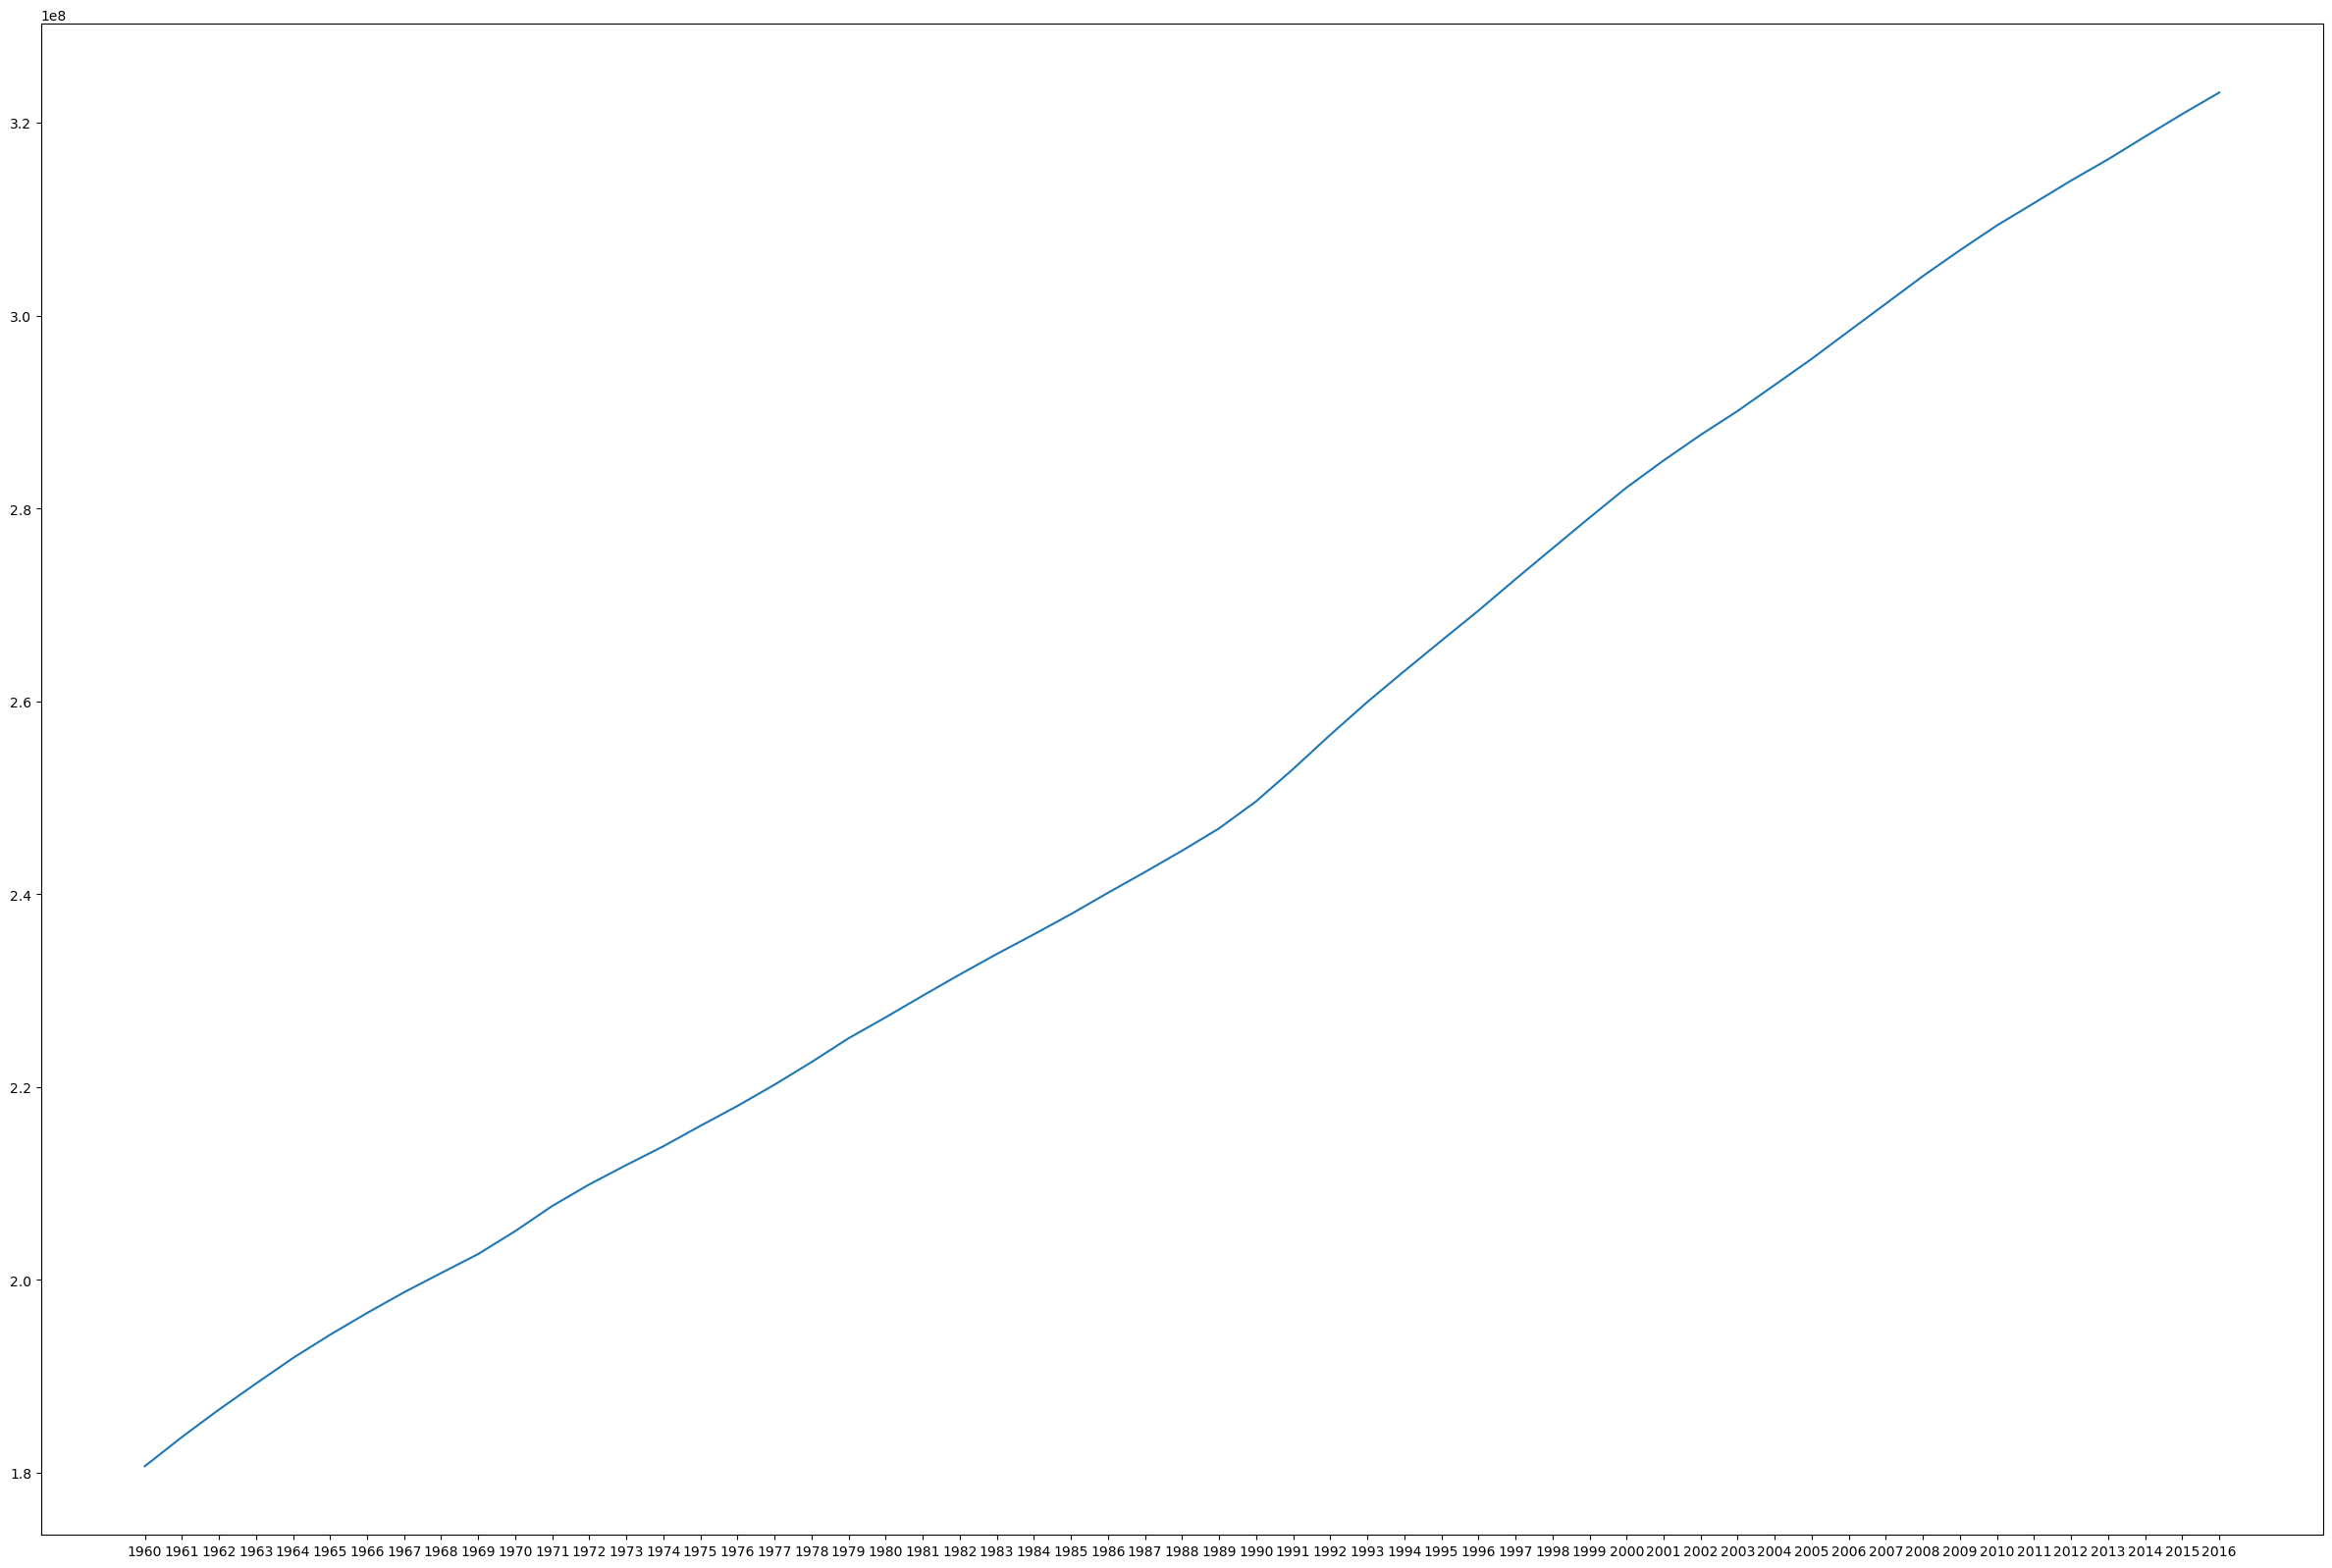

Fertility Rate


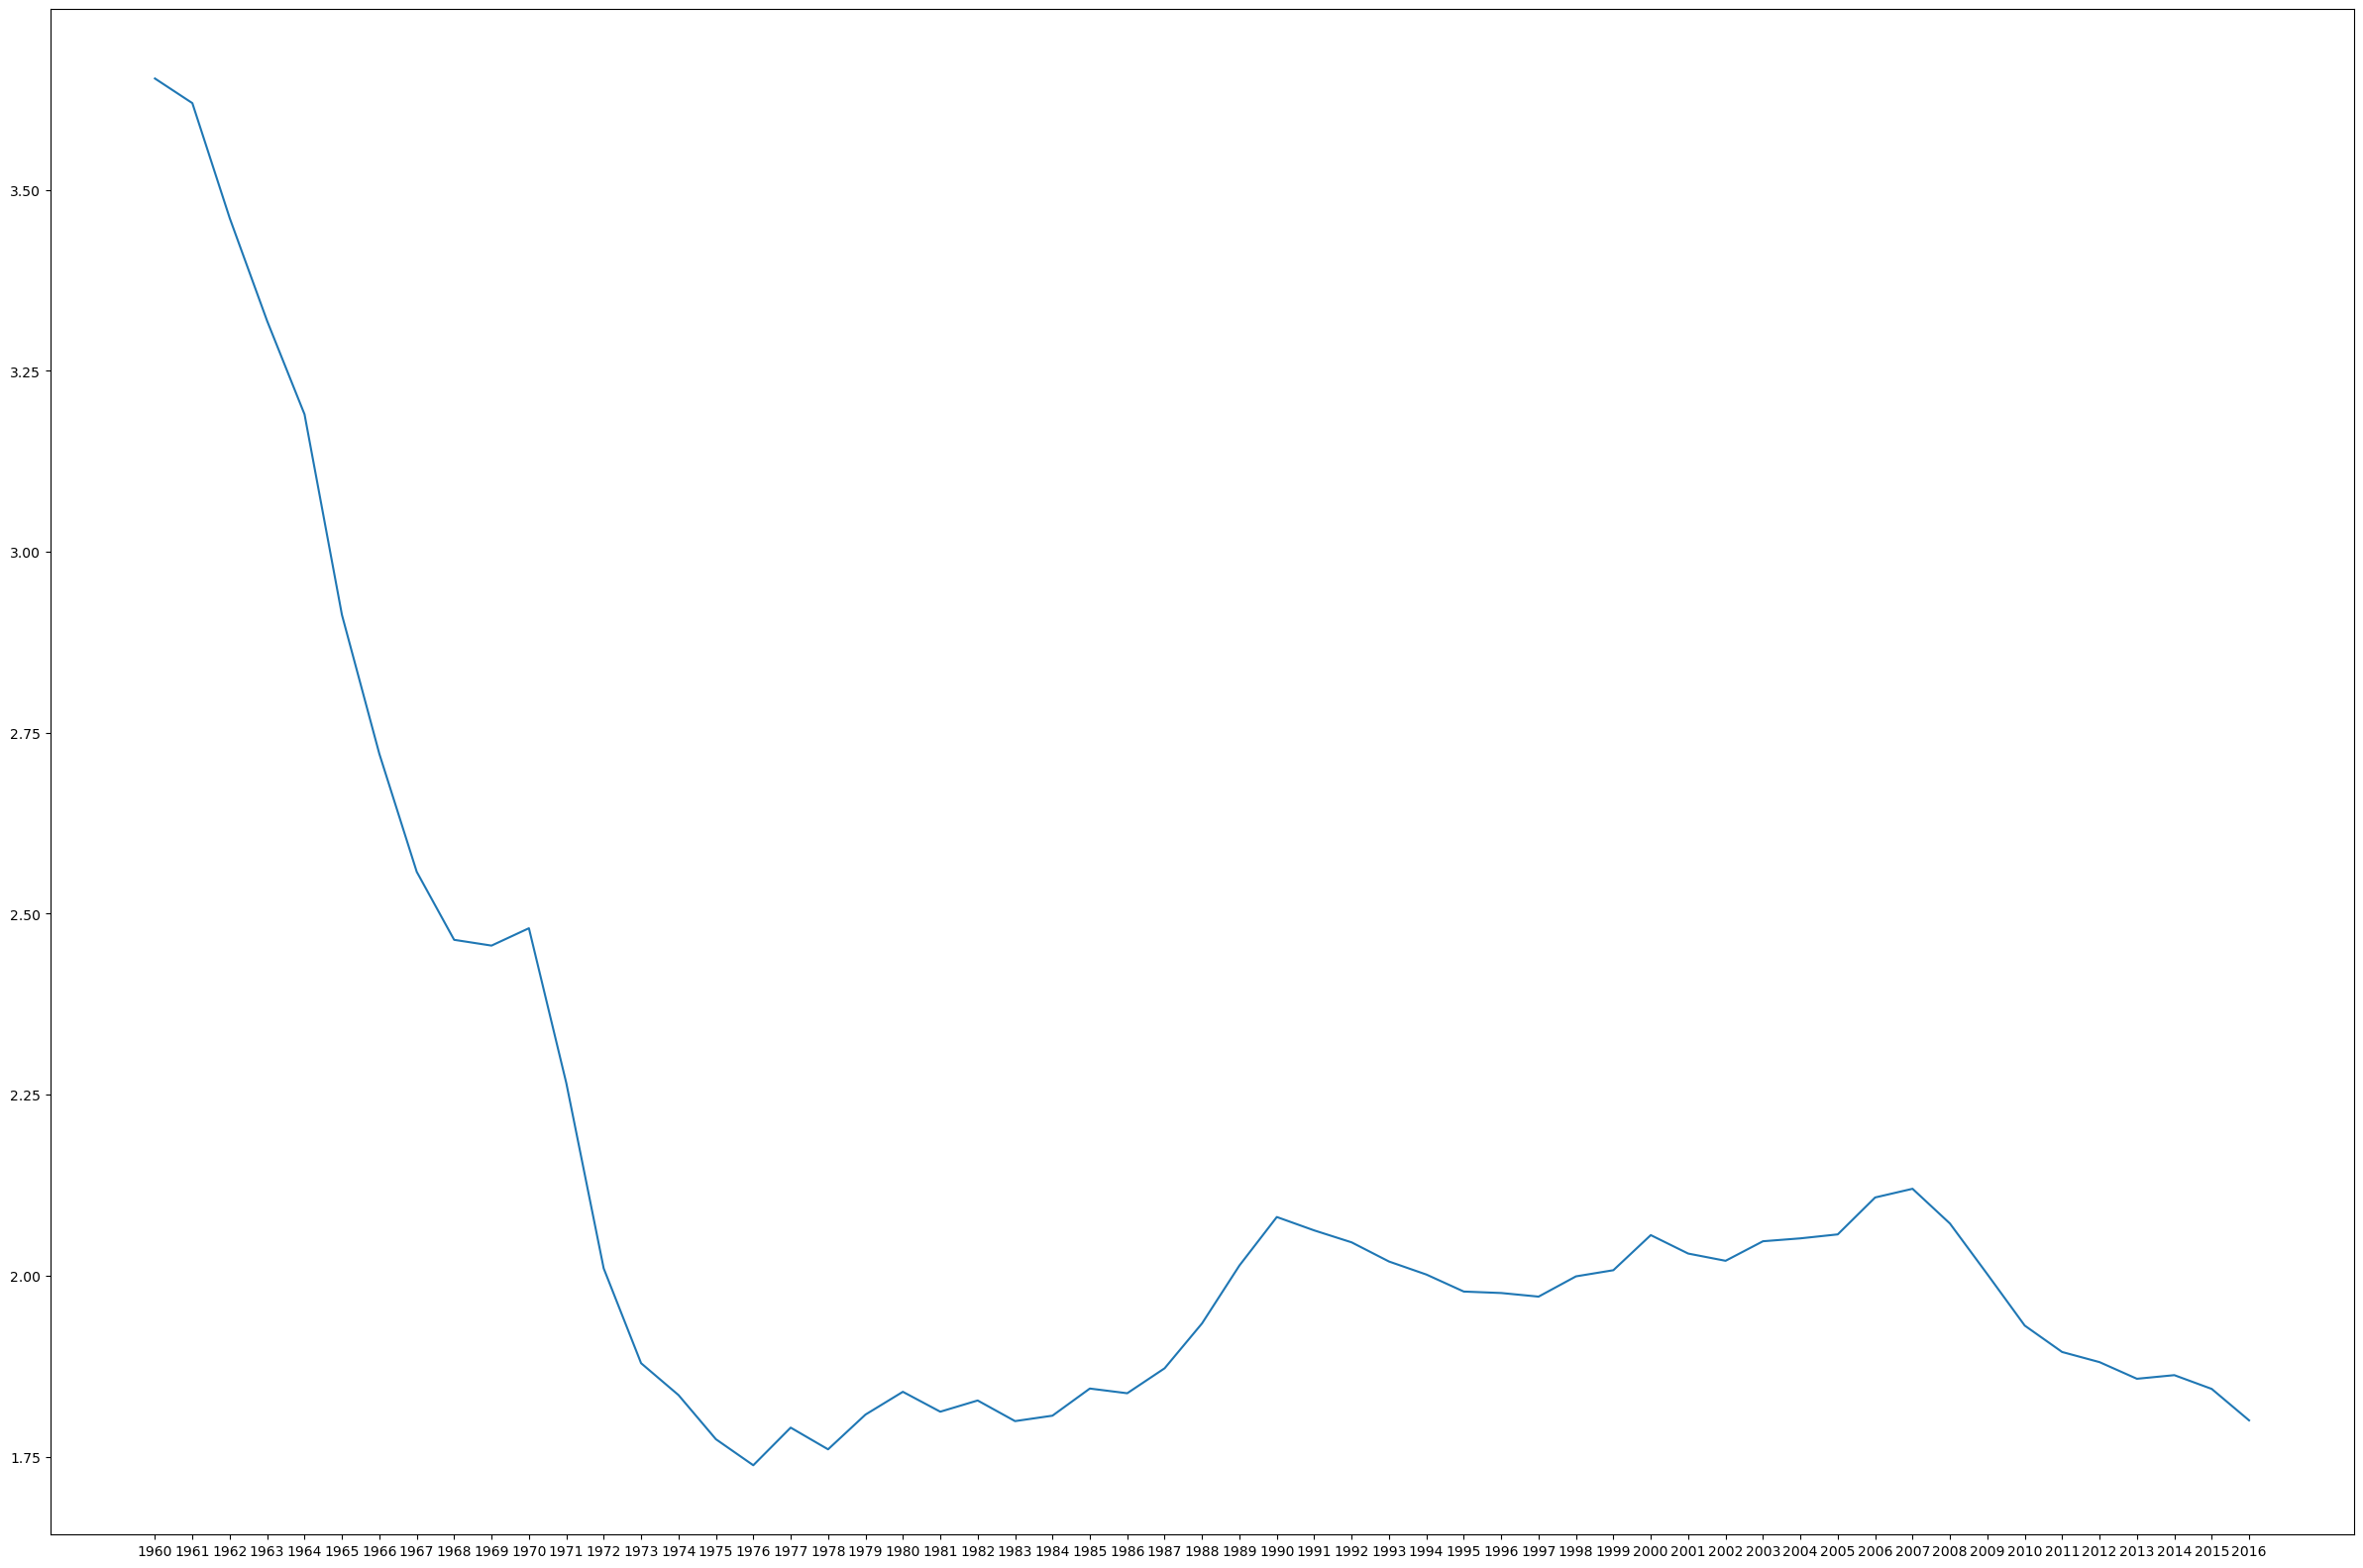

Life Expectancy


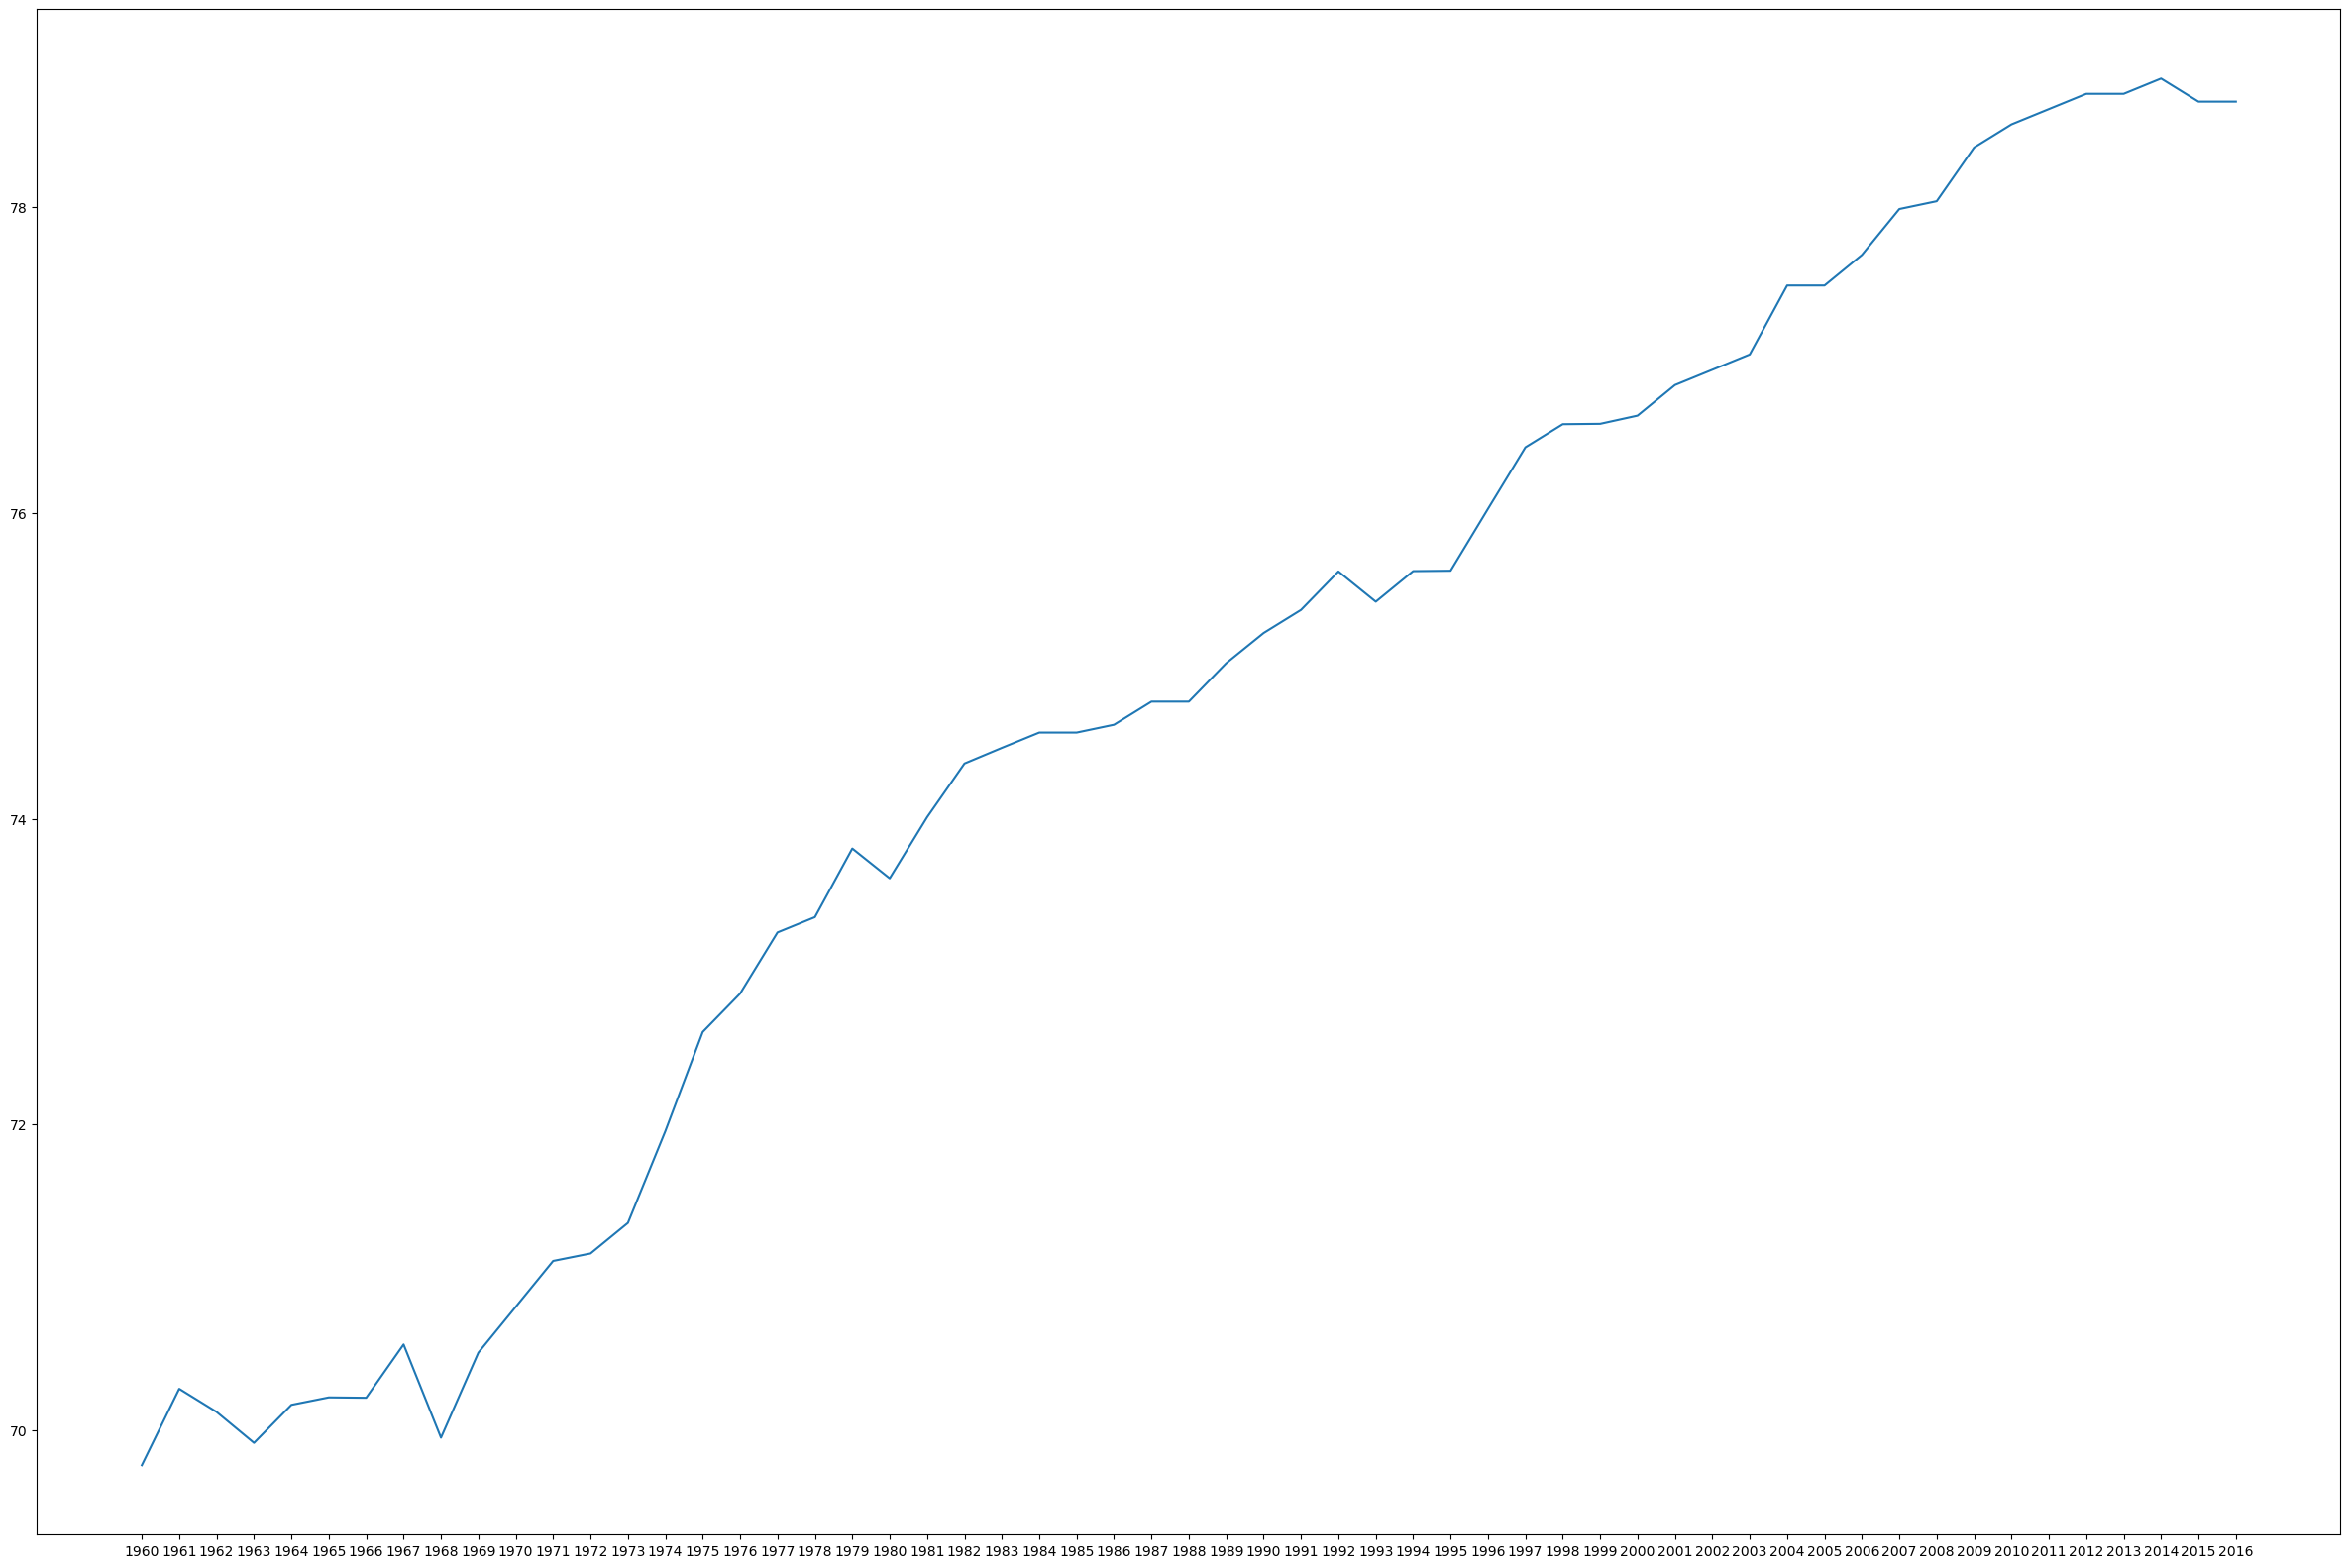

RUS
Country Population


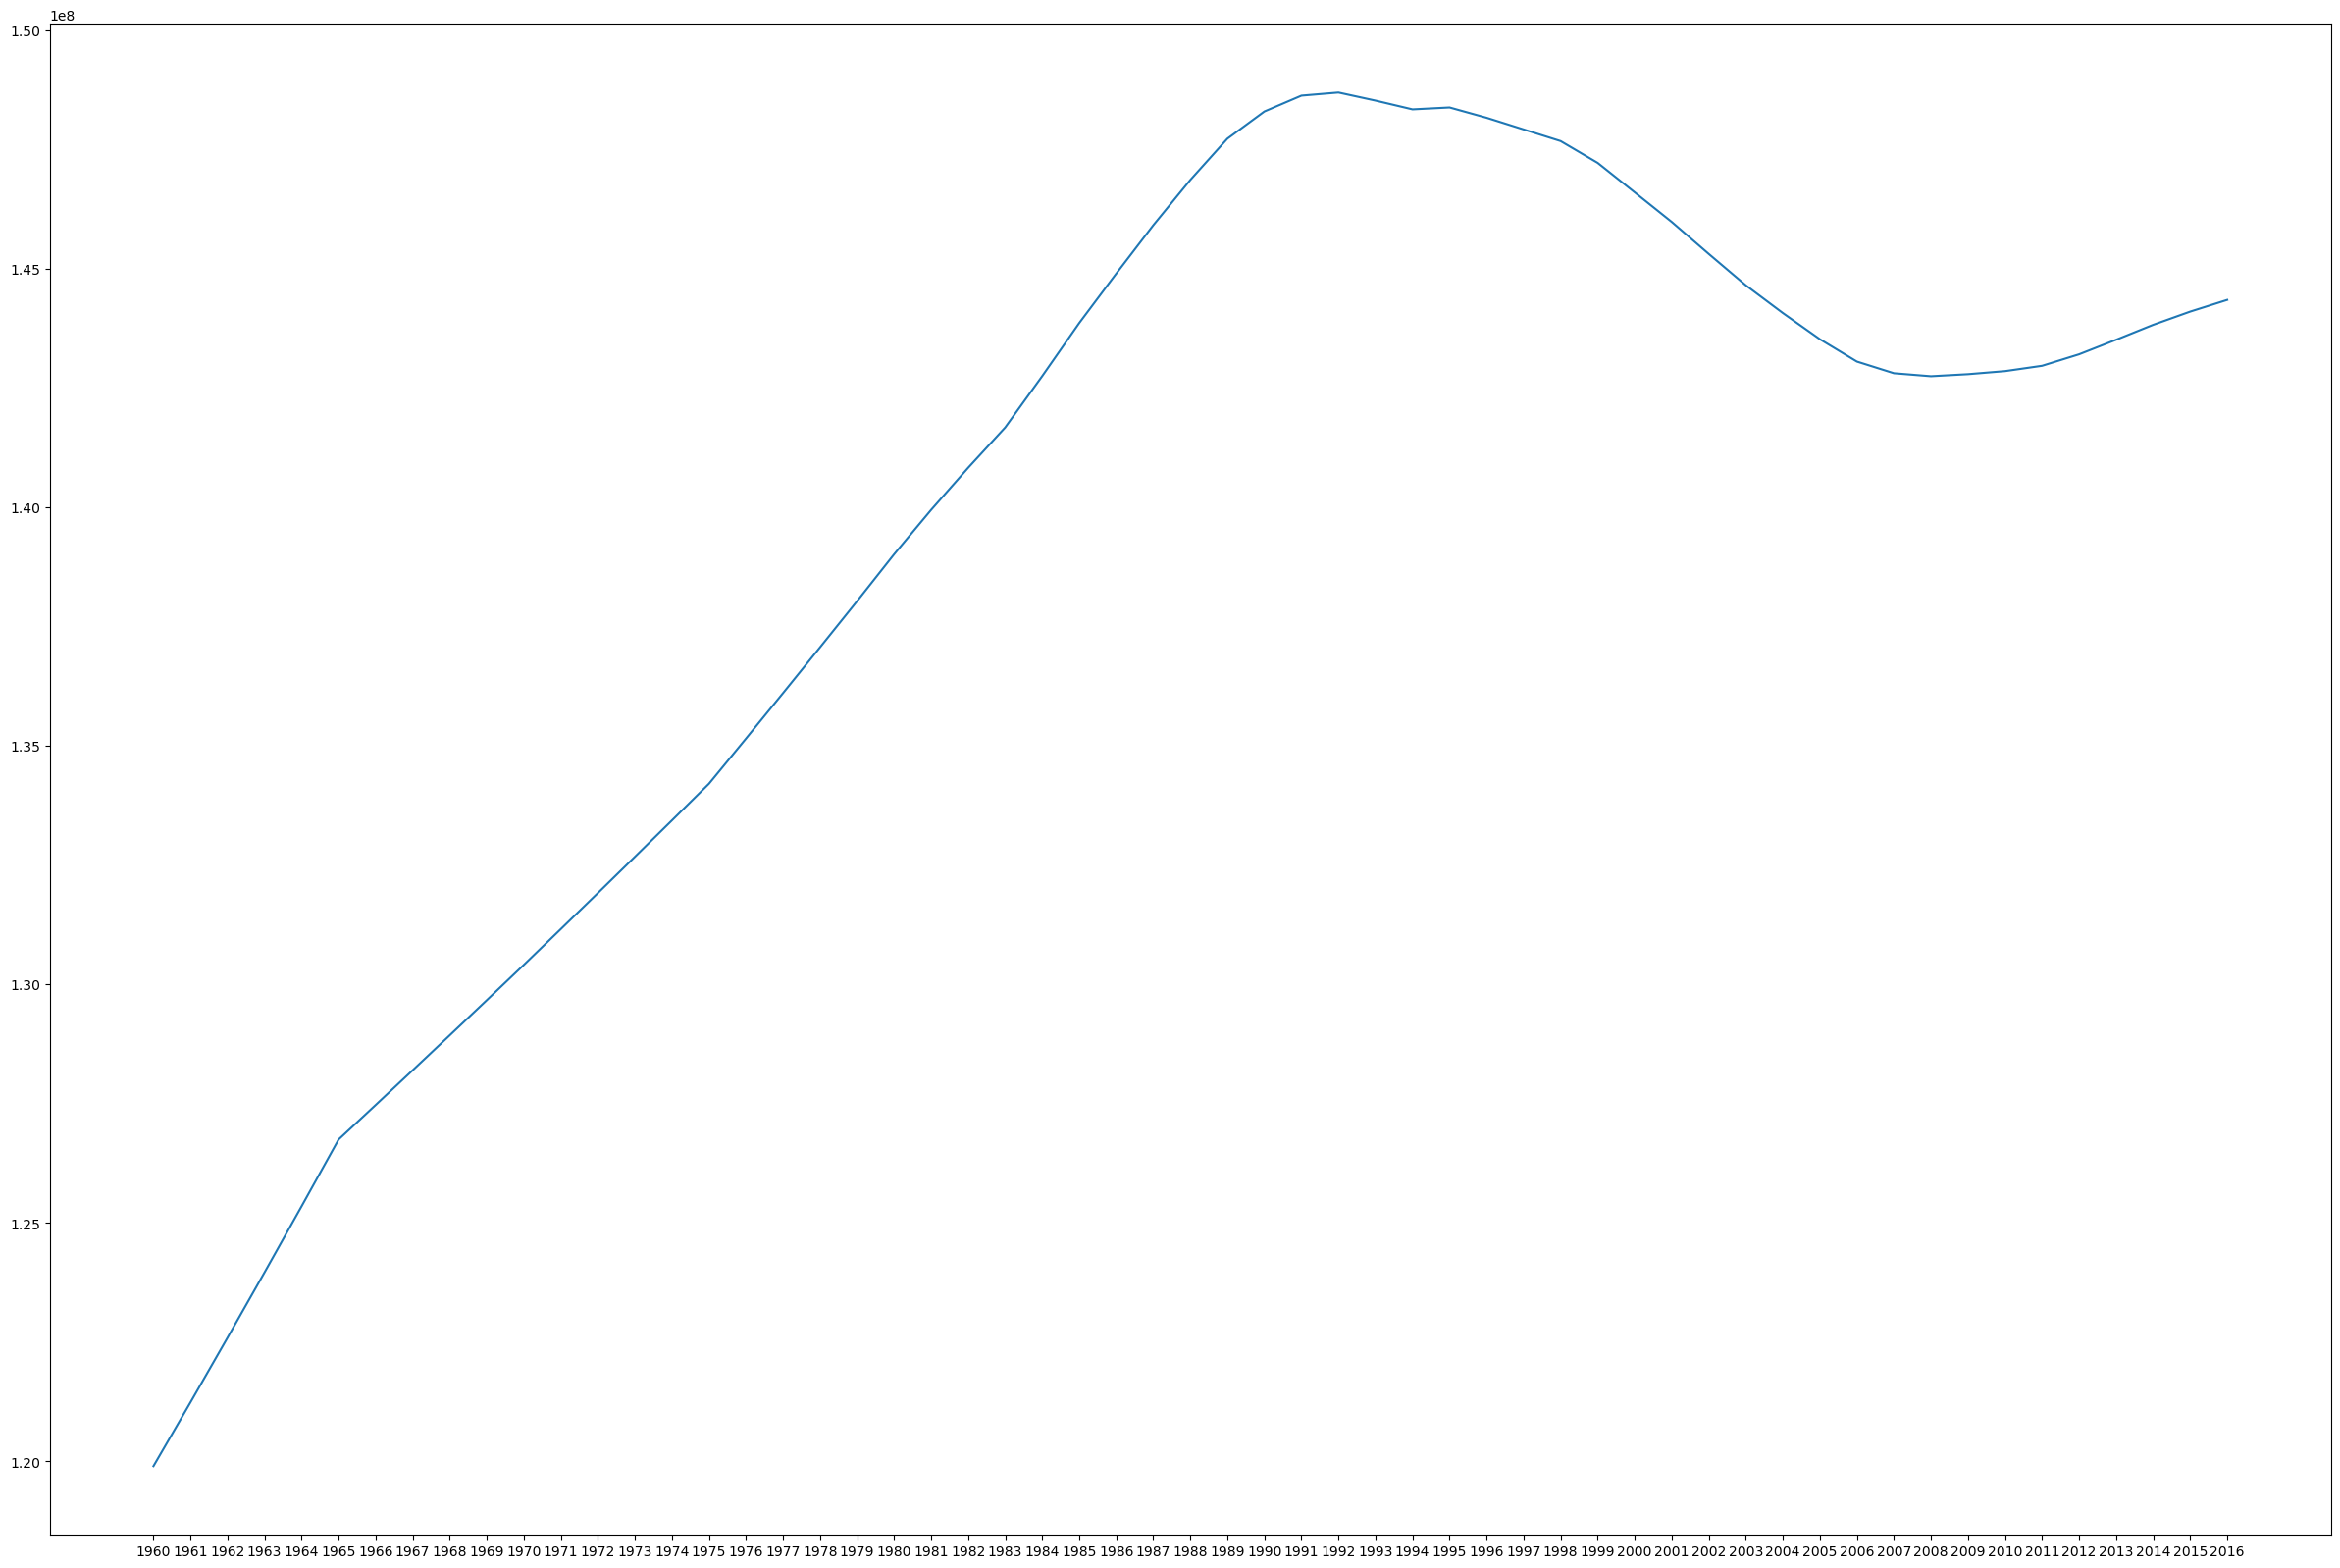

Fertility Rate


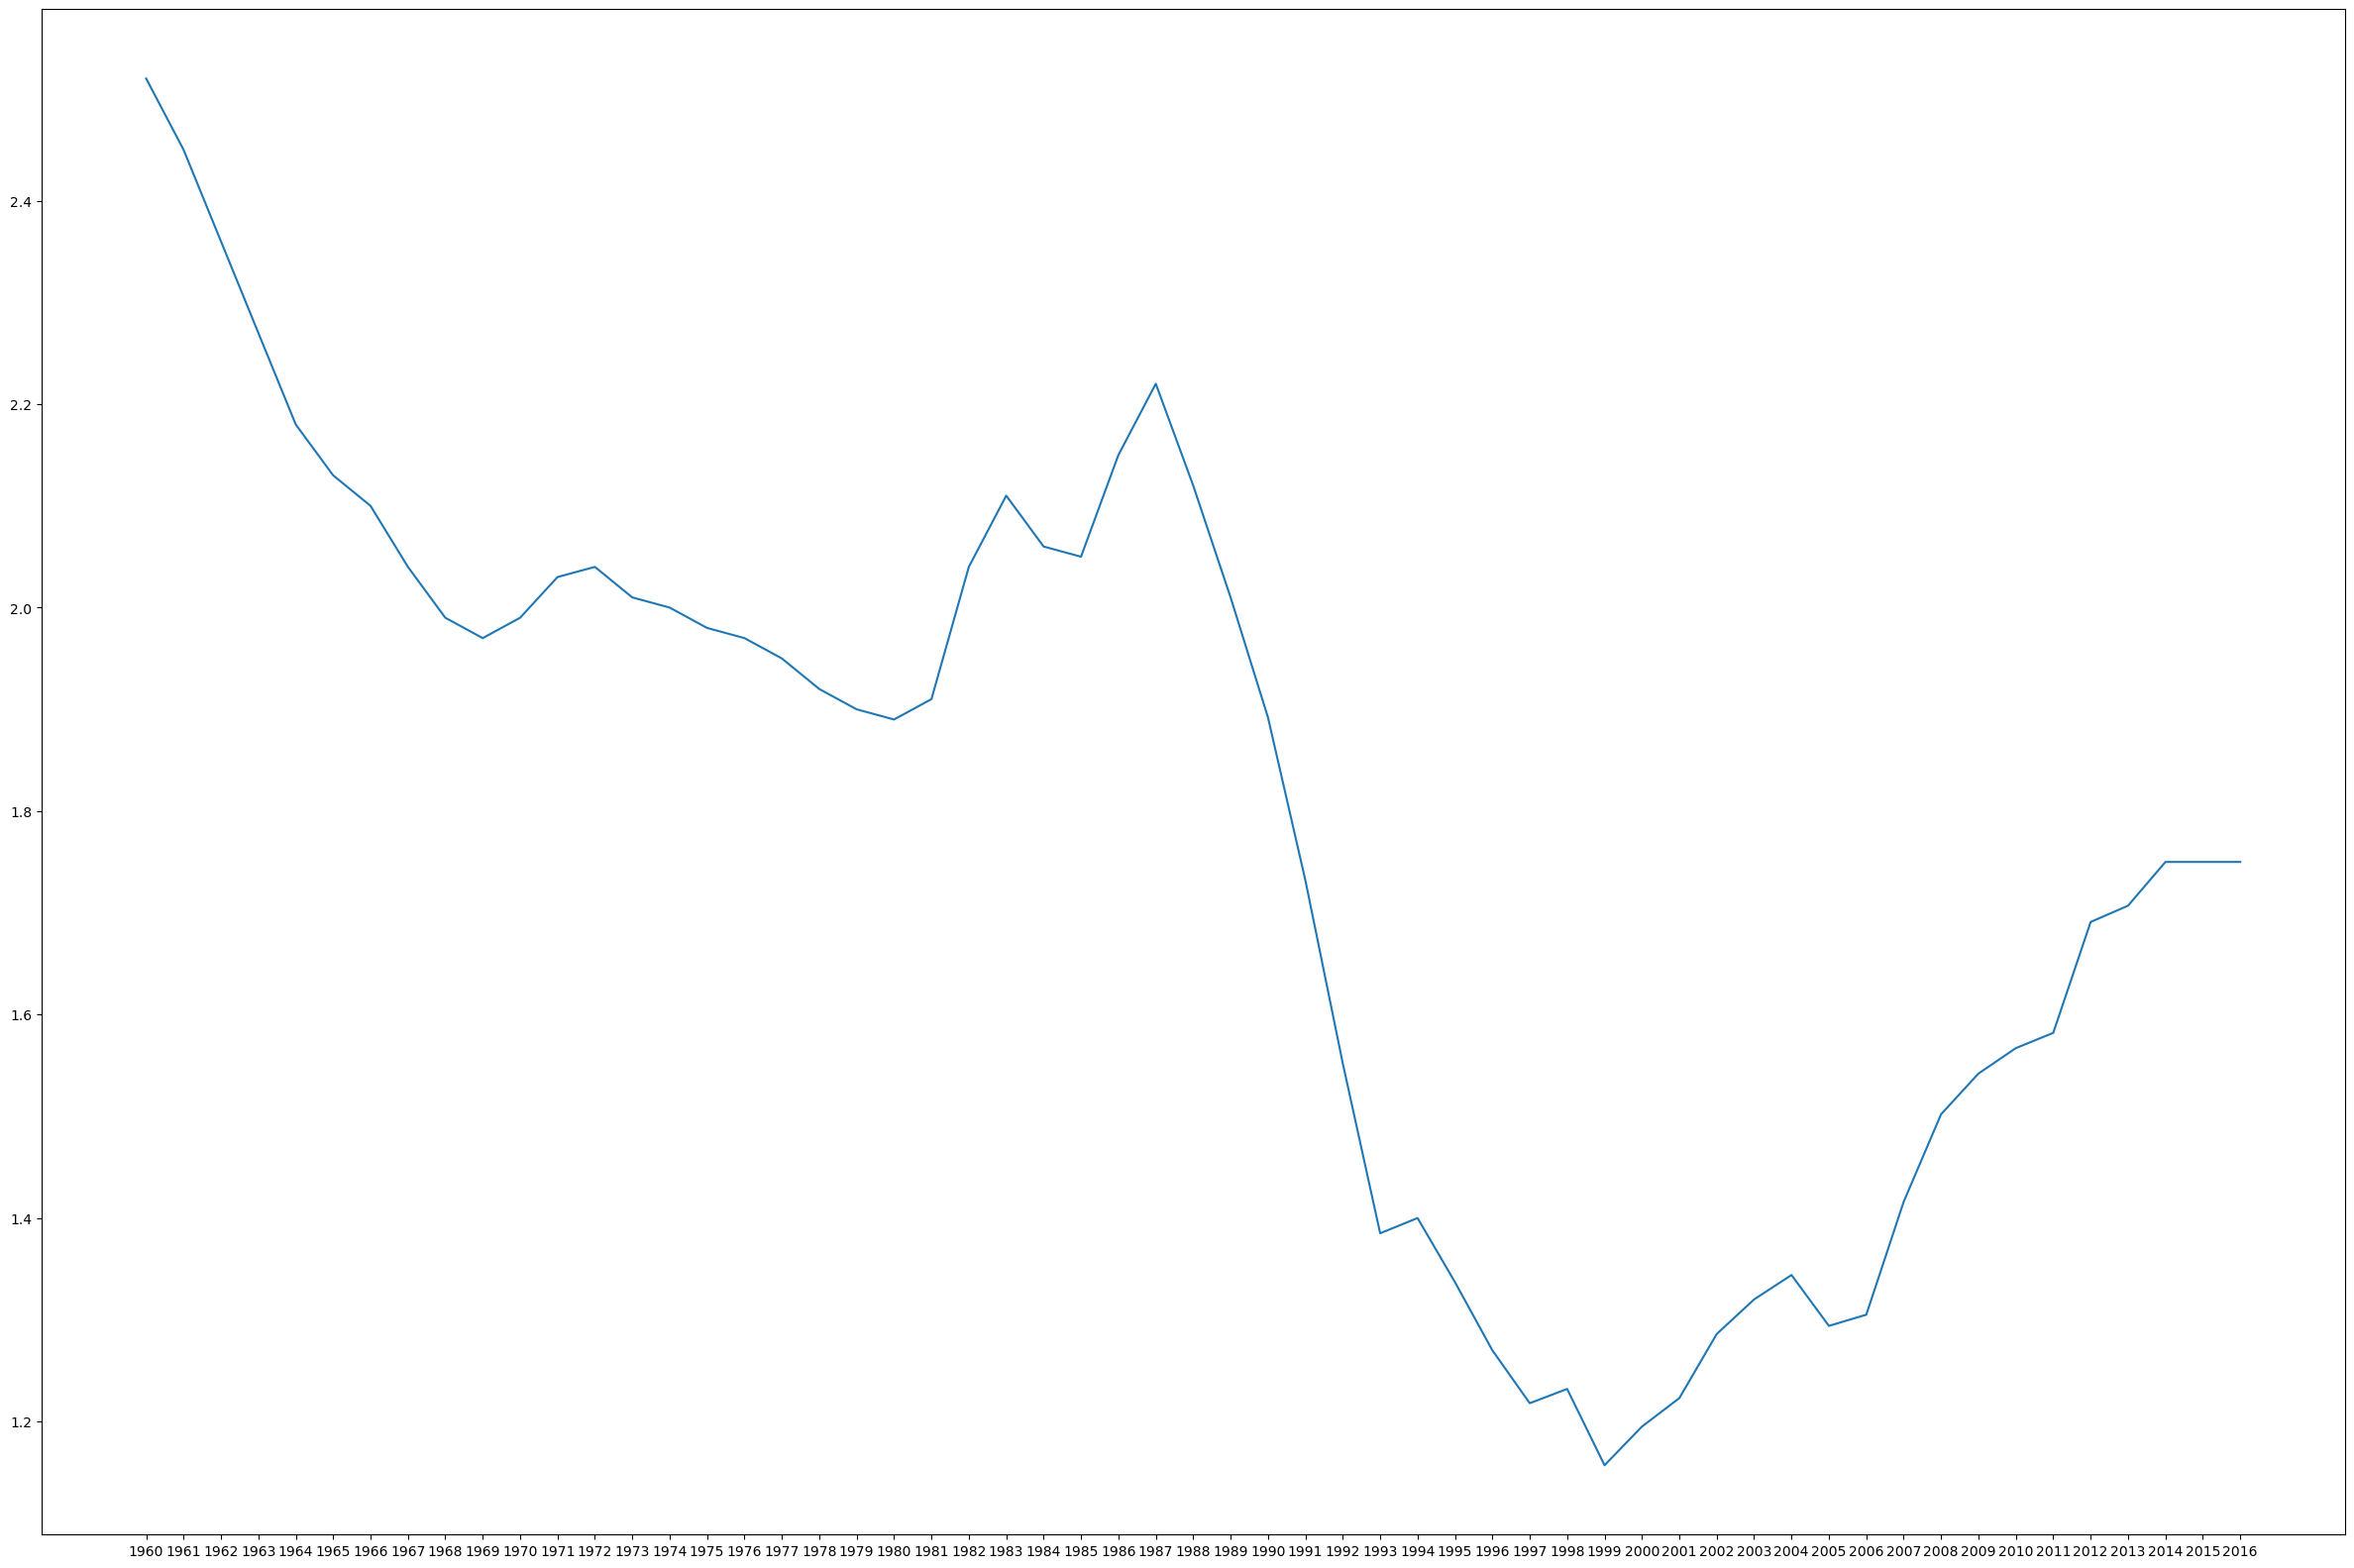

Life Expectancy


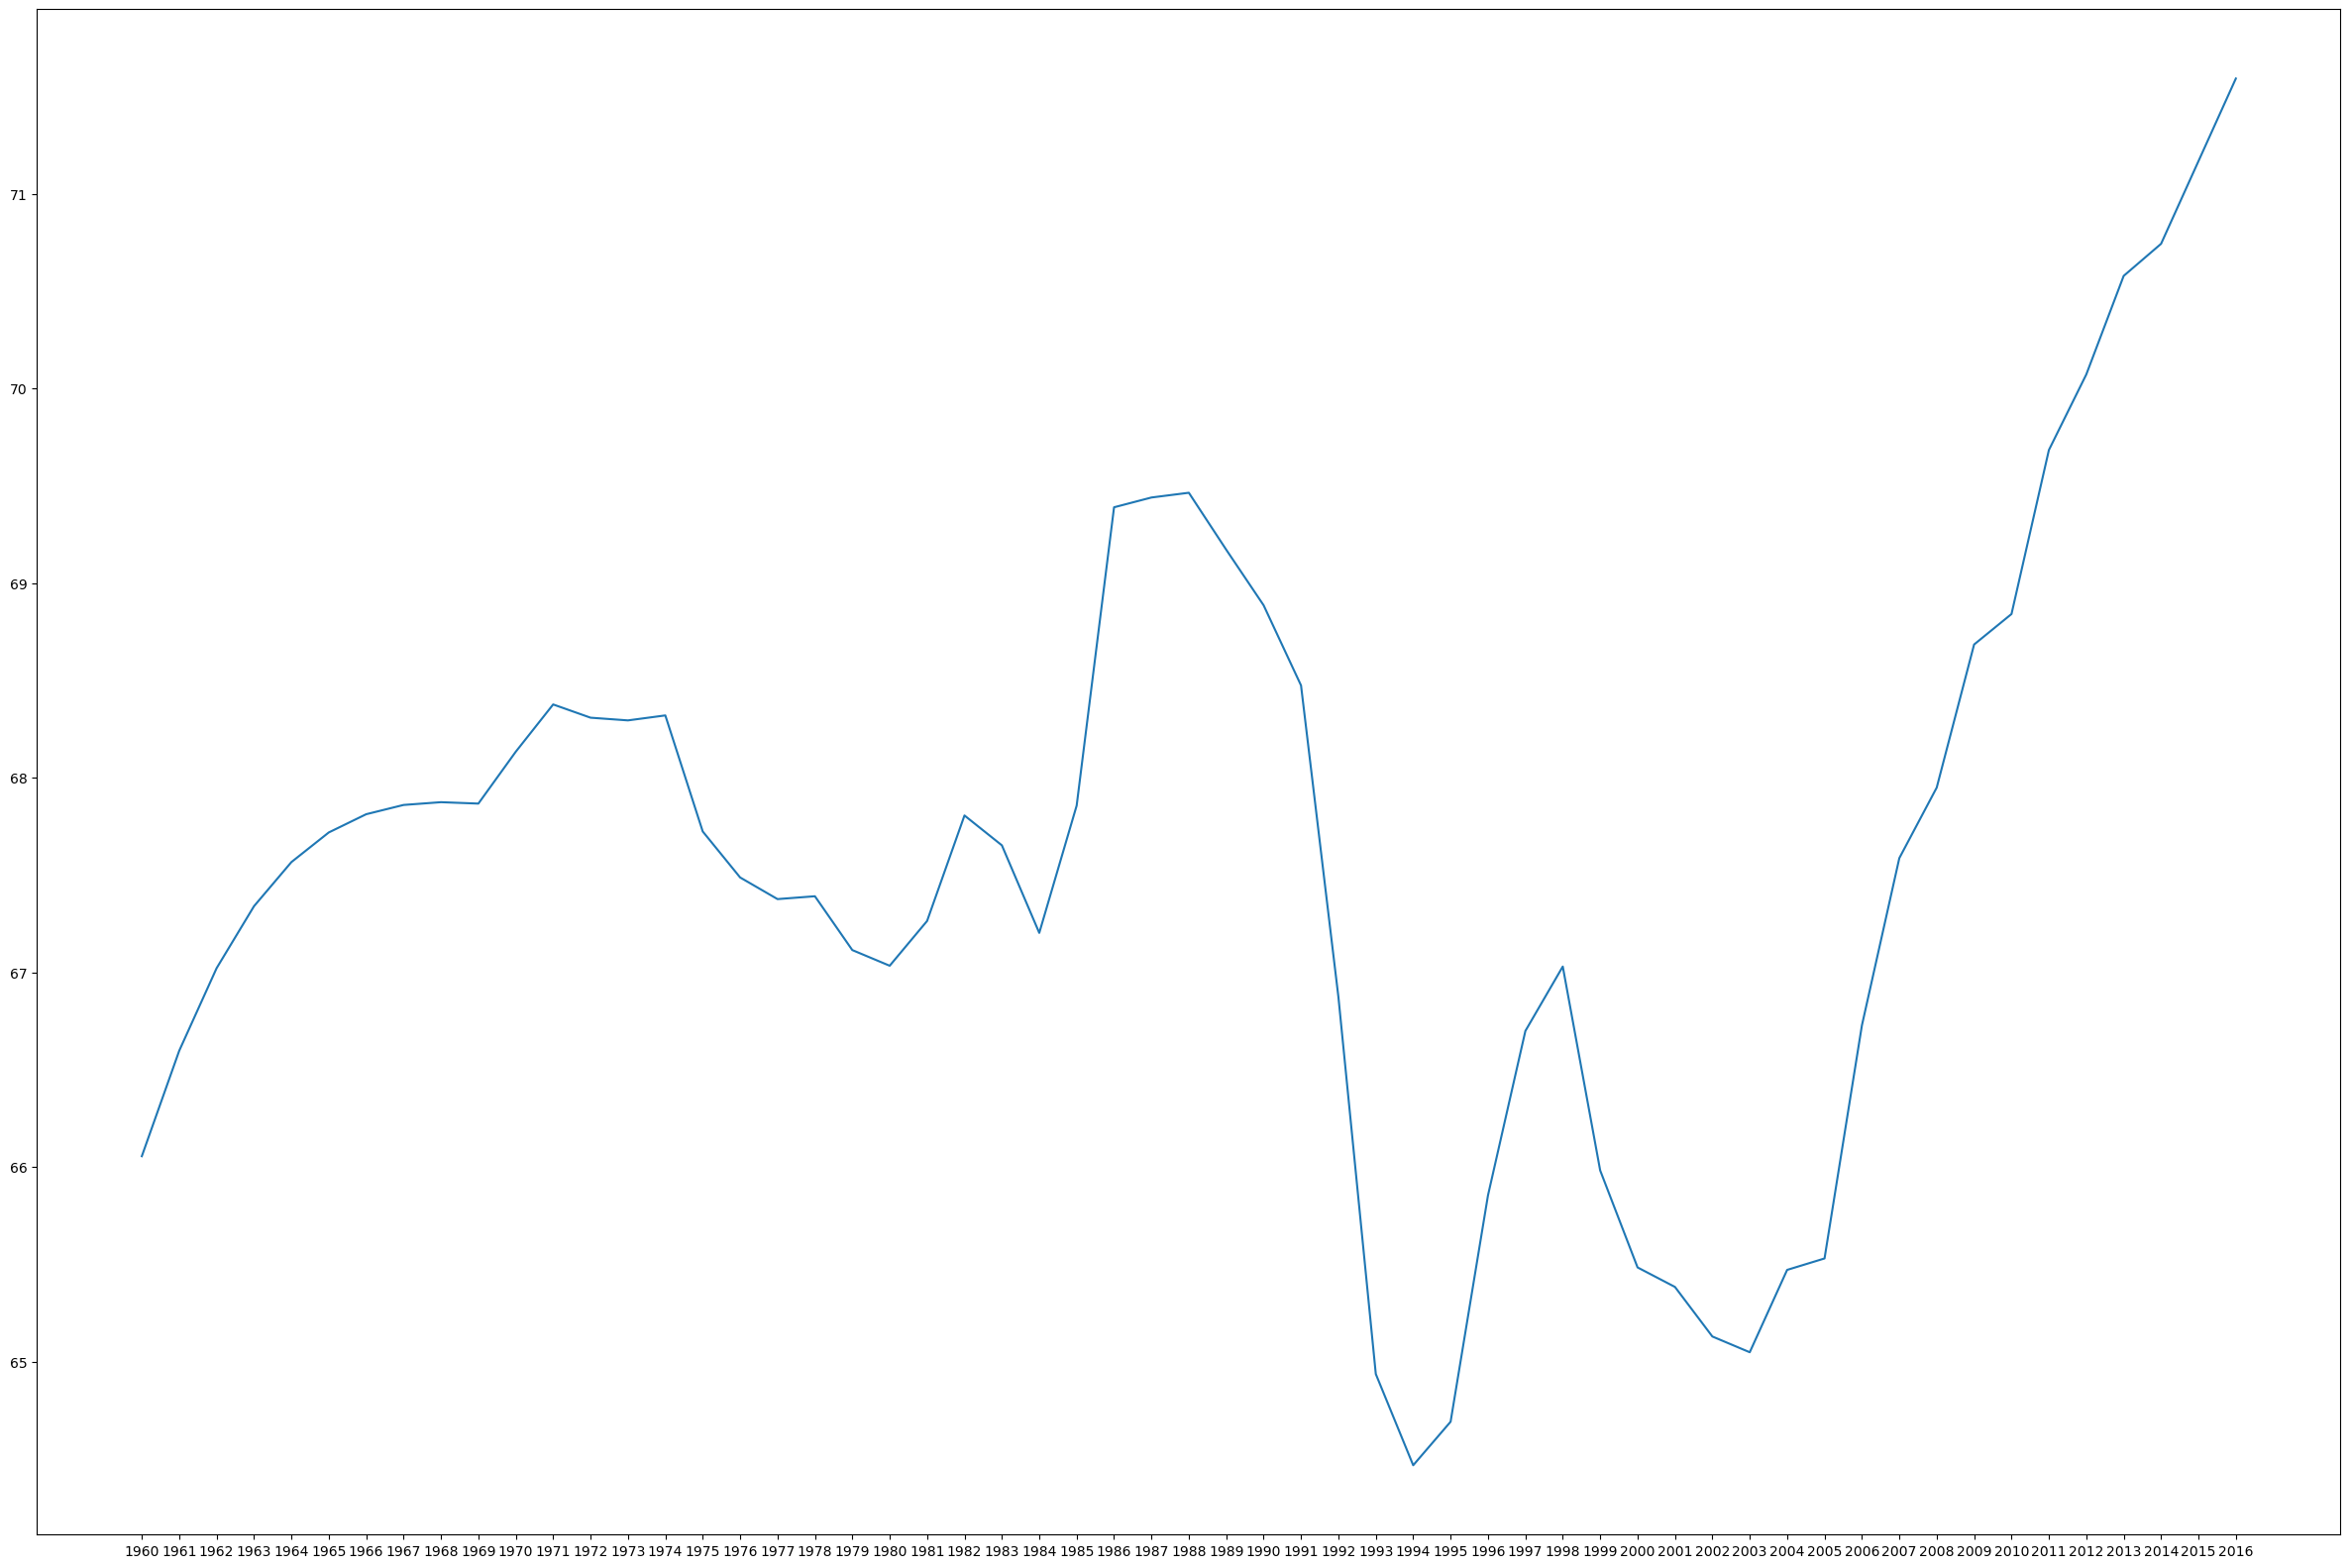

In [5]:
#print("AFG")
#y = cp_df.loc[cp_df["Country Code"] == "AFG"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
#x = np.array(cp_df.loc[cp_df["Country Code"] == "AFG"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,20)
#ax.plot(x,y)
#plt.show()

#print("PRT")
#y = cp_df.loc[cp_df["Country Code"] == "PRT"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
#x = np.array(cp_df.loc[cp_df["Country Code"] == "PRT"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,20)
#ax.plot(x,y)
#plt.show()

print("USA")

print("Country Population")
y = cp_df.loc[cp_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(cp_df.loc[cp_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()

print("Fertility Rate")
y = fr_df.loc[fr_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(fr_df.loc[fr_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()

print("Life Expectancy")
y = le_df.loc[le_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(le_df.loc[le_df["Country Code"] == "USA"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()



print("RUS")

print("Country Population")
y = cp_df.loc[cp_df["Country Code"] == "RUS"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(cp_df.loc[cp_df["Country Code"] == "RUS"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()

print("Fertility Rate")
y = fr_df.loc[fr_df["Country Code"] == "RUS"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(fr_df.loc[fr_df["Country Code"] == "RUS"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()

print("Life Expectancy")
y = le_df.loc[le_df["Country Code"] == "RUS"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
x = np.array(le_df.loc[le_df["Country Code"] == "RUS"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
fig, ax = plt.subplots()
fig.set_size_inches(30,20)
ax.plot(x,y)
plt.show()

#print("GBR")
#y = cp_df.loc[cp_df["Country Code"] == "GBR"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).to_numpy()[0]
#x = np.array(cp_df.loc[cp_df["Country Code"] == "GBR"].drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).columns)
#fig, ax = plt.subplots()
#fig.set_size_inches(30,20)
#ax.plot(x,y)
#plt.show()

From the graphs and data theme, we can assume that these 3 features we want to predict have some correlation between each other.

In [6]:
# used GDP dataset -> https://data.worldbank.org/indicator/NY.GDP.MKTP.CD -> the csv is corrupted when downloaded from the website, need manual changes (delete non-corresponding lines at the beggining)
# also available but without all countries -> https://www.kaggle.com/datasets/rinichristy/countries-gdp-19602020
#  and by continents -> https://www.kaggle.com/datasets/holoong9291/gdp-of-all-countries19602020

gdp_df = pd.read_csv("./imported_datasets/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_4770391.csv")
#display(gdp_df)

In [7]:
#display(cp_df)

In [8]:

Y_list = []
Y_delta_list = []
Y_roc_list = [] # Rate of Change

X_list = []

n_prev_inputs = 2
assert n_prev_inputs >= 1

Y_labels = ["country_population_pred", "fertility_rate_pred", "life_expectancy_pred"]
Y_delta_labels = ["country_population_delta", "fertility_rate_delta", "life_expectancy_delta"]
Y_roc_labels = ["country_population_roc", "fertility_rate_roc", "life_expectancy_roc"]

prev_countrypop_tags = []
prev_fertrate_tags = []
prev_lifeexp_tags = []
for ix in range(n_prev_inputs-1,-1,-1):
    prev_countrypop_tags.append("country_population_prev_"+str(ix))
    prev_fertrate_tags.append("fertility_rate_prev_"+str(ix))
    prev_lifeexp_tags.append("life_expectancy_prev_"+str(ix))

X_labels = []
X_labels.extend(prev_countrypop_tags)
X_labels.append("country_population_curr")
X_labels.extend(prev_fertrate_tags)
X_labels.append("fertility_rate_curr")
X_labels.extend(prev_lifeexp_tags)
X_labels.append("life_expectancy_curr")

X_labels.append("country_code")
X_labels.append("gdp_curr")



for curr_row_ix in range(0, len(cp_df)):

    gdp_country_series = gdp_df.loc[gdp_df["Country Code"] == cp_df.iloc[curr_row_ix]["Country Code"]]

    country_code = gdp_df.iloc[curr_row_ix]["Country Code"]

    cp_row_years = cp_df.drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).iloc[curr_row_ix]
    fr_row_years = fr_df.drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).iloc[curr_row_ix]
    le_row_years = le_df.drop(["Country Name","Country Code","Indicator Name","Indicator Code"], axis=1).iloc[curr_row_ix]

    for curr_column_ix in range(n_prev_inputs+1,len(cp_row_years.to_numpy())):

        assert cp_row_years.axes[0][curr_column_ix-1] == fr_row_years.axes[0][curr_column_ix-1] == le_row_years.axes[0][curr_column_ix-1]
        year = cp_row_years.axes[0][curr_column_ix-1]

        gdp_vals = gdp_country_series[year].values
        assert len(gdp_vals) == 1

        gdp = gdp_vals[0]

        x = []

        for ix in range(n_prev_inputs-1,-1,-1):
            var = cp_row_years.iloc[curr_column_ix-ix-2]
            x.append(var)

        cp_curr = cp_row_years.iloc[curr_column_ix-1]
        cp_pred = cp_row_years.iloc[curr_column_ix]

        x.append(cp_curr)


        for ix in range(n_prev_inputs-1,-1,-1):
            var = fr_row_years.iloc[curr_column_ix-ix-2]
            x.append(var)
        
        fr_curr = fr_row_years.iloc[curr_column_ix-1]
        fr_pred = fr_row_years.iloc[curr_column_ix]

        x.append(fr_curr)


        for ix in range(n_prev_inputs-1,-1,-1):
            var = le_row_years.iloc[curr_column_ix-ix-2]
            x.append(var)

        le_curr = le_row_years.iloc[curr_column_ix-1]
        le_pred = le_row_years.iloc[curr_column_ix]

        x.append(le_curr)
        

        x.append(country_code)
        x.append(gdp)

        y = [cp_pred, fr_pred, le_pred]
        
        cp_delta = cp_pred - cp_curr
        fr_delta = fr_pred - fr_curr
        le_delta = le_pred - le_curr

        y_delta = [cp_delta, fr_delta, le_delta]

        cp_roc = cp_pred / cp_curr
        fr_roc = fr_pred / fr_curr
        le_roc = le_pred / le_curr

        y_roc = [cp_roc, fr_roc, le_roc]

        X_list.append(x)
        Y_list.append(y)
        Y_delta_list.append(y_delta)
        Y_roc_list.append(y_roc)

Y_np = np.array(Y_list)
Y_delta_np = np.array(Y_delta_list)
Y_roc_np = np.array(Y_roc_list)
X_np = np.array(X_list)
#print(Y_np)
#print(len(Y_np))

#print(len(cp_df))
#print(len(cp_row_years))

#_ = (len(cp_df) * len(cp_row_years)) - (2 * len(cp_df))
#print(_)

assert len(Y_np) == len(X_np)

X_df = pd.DataFrame(X_np, columns=X_labels)
#display(X_df)
Y_df = pd.DataFrame(Y_np, columns=Y_labels)
#display(Y_df)
Y_delta_df = pd.DataFrame(Y_delta_np, columns=Y_delta_labels)
#display(Y_delta_df)
Y_roc_df = pd.DataFrame(Y_roc_np, columns=Y_roc_labels)
#display(Y_roc_df)

full_df = X_df.join([ Y_df, Y_delta_df, Y_roc_df ])
#display(full_df)

# Take Care of NaN Values and Assign Correct Types

In [9]:
full_df = full_df.dropna()
full_df = shuffle(full_df, random_state = 13)

nonobject_cols = [col 
for col in full_df 
    if full_df[col].apply(lambda x: 
            is_float(x)
        ).all()
    ]
full_df[nonobject_cols] = full_df[nonobject_cols].astype(float)

# Scale Data

In [10]:
categorical_cols = [col for col in X_df.columns if full_df[col].apply(lambda x: not isinstance(x, float)).all()]
numerical_cols = [col for col in X_df.columns if full_df[col].apply(lambda x: isinstance(x, float)).any()]



numerical_df = full_df[numerical_cols]
categorical_df = full_df[categorical_cols]

Y_df = full_df[Y_df.columns]
Y_delta_df = full_df[Y_delta_df.columns]
Y_roc_df = full_df[Y_roc_df.columns]



# Scale
#X_scaler = StandardScaler()
#X_scaler = MinMaxScaler()
#X_scaler = MinMaxScaler(feature_range=(-1, 1))
#d = X_scaler.fit_transform(numerical_df)
#numerical_df = pd.DataFrame(d,
#             columns=numerical_cols)


#Y_scaler = MinMaxScaler()
#Y_df = pd.DataFrame(Y_scaler.fit_transform(Y_df), columns=Y_df.columns)

#Y_delta_scaler = MinMaxScaler()
#Y_delta_df = pd.DataFrame(Y_delta_scaler.fit_transform(Y_delta_df), columns=Y_delta_df.columns)

#Y_roc_scaler = MinMaxScaler()
#Y_roc_df = pd.DataFrame(Y_roc_scaler.fit_transform(Y_roc_df), columns=Y_roc_df.columns)



# Change categorical features to int
categorical_l = []
for col in categorical_df.columns:
    categorical_ixs = dict((y,x) for x,y in enumerate(np.unique(categorical_df[col].to_numpy())))
    _categorical_l = [ 
        categorical_ixs[val] 
            for val in categorical_df[col].values
        ]
    categorical_l.append(_categorical_l)
categorical_np = np.array(categorical_l)
if len(categorical_l) > 1:
    categorical_df = pd.DataFrame(categorical_np, columns=categorical_cols, dtype=int)
else:
    categorical_df = pd.DataFrame(categorical_np[0], columns=categorical_cols, dtype=int)

#display(numerical_df)
#display(categorical_df)

# Merge full_df
full_df = pd.concat([numerical_df,categorical_df, Y_df,Y_delta_df,Y_roc_df], axis=1).dropna()

#display(full_df)

# One Hot Encoding
#full_df = one_hot_encode_categorical_features(_full_df)
#display(full_df)


X_df = full_df[X_df.columns]
Y_df = full_df[Y_df.columns]
Y_delta_df = full_df[Y_delta_df.columns]
Y_roc_df = full_df[Y_roc_df.columns]

# Divide Dataset

In [11]:

#train_ratio = 0.90
train_ratio = 0.80
test_ratio = 0.15
ivs_ratio = 0.05

train_len = round(len(full_df) * train_ratio)
test_len = round(len(full_df) * test_ratio)
ivs_len = round(len(full_df) * ivs_ratio)




X_train_df = X_df[0:train_len]
X_train_np = X_train_df.to_numpy()

X_test_df = X_df[train_len:train_len+test_len]
X_test_np = X_test_df.to_numpy()

X_ivs_df = X_df[train_len+test_len:train_len+test_len+ivs_len]
X_ivs_np = X_ivs_df.to_numpy()





Y_train_df = Y_df[0:train_len]
Y_train_np = Y_train_df.to_numpy()

Y_delta_train_df = Y_delta_df[0:train_len]
Y_delta_train_np = Y_delta_train_df.to_numpy()

Y_roc_train_df = Y_roc_df[0:train_len]
Y_roc_train_np = Y_roc_train_df.to_numpy()




Y_test_df = Y_df[train_len:train_len+test_len]
Y_test_np = Y_test_df.to_numpy()

Y_delta_test_df = Y_delta_df[train_len:train_len+test_len]
Y_delta_test_np = Y_delta_test_df.to_numpy()

Y_roc_test_df = Y_roc_df[train_len:train_len+test_len]
Y_roc_test_np = Y_roc_test_df.to_numpy()




Y_ivs_df = Y_df[train_len+test_len:train_len+test_len+ivs_len]
Y_ivs_np = Y_ivs_df.to_numpy()

Y_delta_ivs_df = Y_delta_df[train_len+test_len:train_len+test_len+ivs_len]
Y_delta_ivs_np = Y_delta_ivs_df.to_numpy()

Y_roc_ivs_df = Y_roc_df[train_len+test_len:train_len+test_len+ivs_len]
Y_roc_ivs_np = Y_roc_ivs_df.to_numpy()


# Check what features are relevant

In [12]:
sel = SelectFromModel(RandomForestRegressor())
estimator = sel.fit(X_train_df,Y_delta_train_df)
display(estimator)


print(sel.get_support())
selected_feat = X_train_df.columns[(sel.get_support())]
print(len(selected_feat))
print(selected_feat)

SelectFromModel(estimator=RandomForestRegressor())

[False False  True False False False False False False False False]
1
Index(['country_population_curr'], dtype='object')


This means that the random forest regressor used for feature selection only finds the current country population relevant for the model, but this isn't necessarely true, so this being a temporal problem, we disregard this obtained result.

# Running tests using RandomForestRegressors

In [13]:
model = RandomForestRegressor()
model.fit(X_train_np,Y_train_np)
#truth=Y_test_np# np.array([ scaler.inverse_transform(t.reshape(1, -1)) for t in Y_test_np ])
#truth=Y_scaler.inverse_transform(Y_test_np)
truth=Y_test_np

preds=[]
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))
    #preds.append(Y_scaler.inverse_transform(y))
    preds.append(y)
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.9999523288066541
The mse is:  3070055.635989374
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  49498152.25
The Mean Absolute Error is:  468465.4885411233


## Using Delta

In [14]:
model = RandomForestRegressor()
model.fit(X_train_np,Y_delta_train_np)
truth=Y_delta_test_np

preds=[]
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))
    preds.append(y)
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.9990932019215302
The mse is:  225386.08858804769
The Correlation Score is is: 0.9995 (p-value=0.000000e+00)

The Maximum Error is is:  4016066.3200000003
The Mean Absolute Error is:  43733.54699546353


### (Still using Delta) with raw results converted

In [15]:
model = RandomForestRegressor()
model.fit(X_train_np,Y_delta_train_np)
truth=Y_test_np

preds=[]
curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y)
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.9999997369464351
The mse is:  227914.3714548749
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  6274726.6000003815
The Mean Absolute Error is:  43019.95216465159


## Using Rate of Change

In [16]:
model = RandomForestRegressor()
model.fit(X_train_np,Y_roc_train_np)
truth=Y_roc_test_np

preds=[]
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))
    preds.append(list(y))
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.672724419985684
The mse is:  0.012226481775112279
The Correlation Score is is: 0.8213 (p-value=0.000000e+00)

The Maximum Error is is:  0.20886936559830382
The Mean Absolute Error is:  0.004948772993100164


### (Still using Rate of Change) with raw results converted

In [17]:
model = RandomForestRegressor()
model.fit(X_train_np,Y_roc_train_np)
truth=Y_test_np

preds=[]
curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))[0]
    y = np.array([x[curr_cp_ix] * y[0], x[curr_fr_ix] * y[1], x[curr_le_ix] * y[2]])
    preds.append(y)
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.9999990320653183
The mse is:  437191.6736796969
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  8696255.400945663
The Mean Absolute Error is:  75497.44784053067


We can observe, that using delta we can achieve the best results. So, we disregard raw predictions or rate of change usage and go with the Delta computation aproach.

# Now, we separate the different features to predict and compute one individualy, to see if it fairs better

We are only taking the best of the ones we tested for comparations, and trying out country population first.

Thus, this test is for the use of the Delta computation to predict country population only.

In [18]:
model = RandomForestRegressor()
model.fit(X_train_np,Y_delta_train_df["country_population_delta"].to_numpy())
truth=Y_test_df["country_population_pred"].to_numpy()

preds=[]
curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y[0])
preds=np.array(preds)

printRegStatistics(truth,preds)

The RVE is:  0.9999997417186166
The mse is:  375342.06098282087
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  5014499.93999958
The Mean Absolute Error is:  128932.92671885606


In [19]:
#display([ [truth[i], preds[i] ] for i in range(len(truth)) ])

With this, we observe that it is of no use to try and separate each prediction feature, computing the batch actually can have better or equal results than each individualy! Which makes sense, when we remember the previously generated graphs, we could see that they had some correlation on the predicted values.

## Let's optimize this and try different models

### Chosing which models to optimize

First, we use a general simple package (lazypredict) to test out a bunch of sickitlearn models at once. This is used only to select which models we want to try out to optimize.

This package doesn't work well with batch predictions, so we use the country_population feature to predict. And even with this, some models will fail due to the non-scaled Y and incompatabilities with the desired value-range of predictions.

This could also takes a while to compute!

In [20]:
"""
reg = LazyRegressor(verbose = 0,
                    ignore_warnings = False,
                    custom_metric = None,
                    random_state = 13
                )
models, predictions = reg.fit(X_train_np, X_test_np, Y_delta_train_df["country_population_delta"].to_numpy(), Y_delta_test_df["country_population_delta"].to_numpy())
model_dictionary = reg.provide_models(X_train_np, X_test_np, Y_delta_train_df["country_population_delta"].to_numpy(), Y_delta_test_df["country_population_delta"].to_numpy())

with open("./lazypredict_models.dump", "wb") as o:
    pickle.dump(models,o)

display(models)



# Logs:

#  21%|██▏       | 9/42 [00:02<00:11,  2.88it/s]GammaRegressor model failed to execute
# Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
#  71%|███████▏  | 30/42 [00:16<00:05,  2.15it/s]PoissonRegressor model failed to execute
# Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.
# 100%|██████████| 42/42 [1:11:36<00:00, 102.31s/it]  

"""

'\nreg = LazyRegressor(verbose = 0,\n                    ignore_warnings = False,\n                    custom_metric = None,\n                    random_state = 13\n                )\nmodels, predictions = reg.fit(X_train_np, X_test_np, Y_delta_train_df["country_population_delta"].to_numpy(), Y_delta_test_df["country_population_delta"].to_numpy())\nmodel_dictionary = reg.provide_models(X_train_np, X_test_np, Y_delta_train_df["country_population_delta"].to_numpy(), Y_delta_test_df["country_population_delta"].to_numpy())\n\nwith open("./lazypredict_models.dump", "wb") as o:\n    pickle.dump(models,o)\n\ndisplay(models)\n\n\n\n# Logs:\n\n#  21%|██▏       | 9/42 [00:02<00:11,  2.88it/s]GammaRegressor model failed to execute\n# Some value(s) of y are out of the valid range of the loss \'HalfGammaLoss\'.\n#  71%|███████▏  | 30/42 [00:16<00:05,  2.15it/s]PoissonRegressor model failed to execute\n# Some value(s) of y are out of the valid range of the loss \'HalfPoissonLoss\'.\n# 100%|█████████

In [21]:
with open("./lazypredict_models.dump", "rb") as o:
    models = pickle.load(o)

display(models)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,1.00,1.00,219095.65,1.56
LassoLarsCV,1.00,1.00,347054.76,0.04
LassoLarsIC,1.00,1.00,347054.76,0.02
TransformedTargetRegressor,1.00,1.00,347054.76,0.01
LinearRegression,1.00,1.00,347054.76,0.01
BayesianRidge,1.00,1.00,347114.26,0.04
RandomForestRegressor,1.00,1.00,370370.85,3.92
RANSACRegressor,1.00,1.00,431050.73,0.03
LassoLars,1.00,1.00,443130.61,0.01


With this table, we set our plan to optimize a LinearRegression, a SVR and a RandomForestsRegressor Model. Finaly, we will try and get the best result possible with ExtraTreesRegressor, even though it will be slower, like the RandomForestsRegressor.

# LinearRegression
## Simply running the Model without optimization

In [22]:
model = LinearRegression()
model.fit(X_train_np,Y_delta_train_np)
truth=Y_test_np

preds=[]
curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y)
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.9999997966926134
The mse is:  200372.15703502297
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  5434967.502389073
The Mean Absolute Error is:  37186.270066838326


## With K Fold Validation

In [23]:
#fit_intercept = [True]
fit_intercept = [True,False]
#normalize = ["deprecated"]
normalize = [True, False]
#copy_X = [True]
copy_X = [True, False]
#n_jobs = [None]
n_jobs = [None,1,30,50,55,60]
#positive = [False]
positive = [True,False]

hyperparams = list(product(fit_intercept, normalize, copy_X, n_jobs, positive))
best_model, best_hyperparams_possib, best_score = kfold_val(SupportedModelType.LINEAR_REGRESSION, ["mse"], X_train_df, X_test_df, pd.concat([Y_delta_train_df, Y_delta_test_df], axis=0), pd.concat([Y_train_df, Y_test_df], axis=0), hyperparams)
best_hyperparams = best_hyperparams_possib[0]

truth=Y_ivs_np

preds=[]
curr_cp_ix = X_ivs_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_ivs_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_ivs_df.columns.to_list().index("life_expectancy_curr")
for x in X_ivs_np:
    y = best_model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y)
preds=np.array(preds)

print()
print("Best Linear Regressor Results")

truth_total = []
truth_cp = []
truth_fr = []
truth_le = []
for t in truth:
    truth_total.append((t[0] * t[1] * t[2]) / 5)
    truth_cp.append(t[0])
    truth_fr.append(t[1])
    truth_le.append(t[2])
truth_total = np.array(truth_total)
truth_cp = np.array(truth_cp)
truth_fr = np.array(truth_fr)
truth_le = np.array(truth_le)

preds_total = []
preds_cp = []
preds_fr = []
preds_le = []
for p in preds:
    preds_total.append((p[0] * p[1] * p[2]) / 5)
    preds_cp.append(p[0])
    preds_fr.append(p[1])
    preds_le.append(p[2])
preds_total = np.array(preds_total)
preds_cp = np.array(preds_cp)
preds_fr = np.array(preds_fr)
preds_le = np.array(preds_le)


print()
print()
print("For the country population")
print()
printRegStatistics(truth_cp,preds_cp)

print()
print()
print("For the fertility rate")
print()
printRegStatistics(truth_fr,preds_fr)

print()
print()
print("For the life expectancy")
print()
printRegStatistics(truth_le,preds_le)

print()
print()
print("Total Flattened")
print()
printRegStatistics(truth.flatten(),preds.flatten())

print()
print()
print("Total")
print()
printRegStatistics(truth_total,preds_total)


print()
print()


fit_intercept,\
    normalize,\
    copy_X,\
    n_jobs,\
    positive = best_hyperparams
print(f"With hyperparams: fit_intercept={fit_intercept}; normalize={normalize}; copy_X={copy_X}; n_jobs={n_jobs}; positive={positive}.")
if len(best_hyperparams_possib) == 1:
    print("No other hyperparam combinations.")
else:
    print(f"{str(len(best_hyperparams_possib) - 1)} other hyperparams with the same scores:")
    for p in best_hyperparams_possib:
        fit_intercept,\
            normalize,\
            copy_X,\
            n_jobs,\
            positive = p
        print(f"With hyperparams: fit_intercept={fit_intercept}; normalize={normalize}; copy_X={copy_X}; n_jobs={n_jobs}; positive={positive}.")


Best Linear Regressor Results


For the country population

The RVE is:  0.9999998082694822
The mse is:  329387.92678138695
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  5898102.585692406
The Mean Absolute Error is:  86338.19756183107


For the fertility rate

The RVE is:  0.9995849998909416
The mse is:  0.0392008771047105
The Correlation Score is is: 0.9998 (p-value=0.000000e+00)

The Maximum Error is is:  0.421196132695127
The Mean Absolute Error is:  0.01957113113905548


For the life expectancy

The RVE is:  0.9997100207975071
The mse is:  0.1776551402871918
The Correlation Score is is: 0.9999 (p-value=0.000000e+00)

The Maximum Error is is:  1.8786818075138356
The Mean Absolute Error is:  0.08974679672894503


Total Flattened

The RVE is:  0.9999998222321135
The mse is:  190172.20819507548
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  5898102.585692406
The Mean Absolute Error is:  28779.43562658631




# SVR
## Simply running the Model without optimization
### With PCA Kernel for dimentionality reduction

In [24]:
pca_kernel = KernelPCA()
pca_kernel.fit(X_train_np,Y_delta_train_df["country_population_delta"].to_numpy())

pca_X_train_np = pca_kernel.transform(X_train_np)
pca_X_test_np = [ pca_kernel.transform(x.reshape(1, -1)) for x in X_test_np ]

# This one needs to be used for each prediction feature

cp_model = SVR()

cp_model.fit(pca_X_train_np,Y_delta_train_df["country_population_delta"].to_numpy())

fr_model = SVR()

fr_model.fit(pca_X_train_np,Y_delta_train_df["fertility_rate_delta"].to_numpy())

le_model = SVR()
le_model.fit(pca_X_train_np,Y_delta_train_df["life_expectancy_delta"].to_numpy())

truth=Y_test_np

preds=[]
curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
for ix in range(len(pca_X_test_np)):

    x = pca_X_test_np[ix]

    cp_y = cp_model.predict(x.reshape(1, -1))[0]
    cp_y += X_test_np[ix][curr_cp_ix]
    
    fr_y = fr_model.predict(x.reshape(1, -1))[0]
    fr_y += X_test_np[ix][curr_fr_ix]
    
    le_y = le_model.predict(x.reshape(1, -1))[0]
    le_y += X_test_np[ix][curr_le_ix]

    preds.append(np.array([ cp_y, fr_y, le_y ]))
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.9997178629910263
The mse is:  7599482.111291332
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  82426878.54295969
The Mean Absolute Error is:  1470333.9239080637


### Without PCA Kernel

In [25]:
# this one needs to be used for each prediction feature

cp_model = SVR()
cp_model.fit(X_train_np,Y_delta_train_df["country_population_delta"].to_numpy())

fr_model = SVR()
fr_model.fit(X_train_np,Y_delta_train_df["fertility_rate_delta"].to_numpy())

le_model = SVR()
le_model.fit(X_train_np,Y_delta_train_df["life_expectancy_delta"].to_numpy())

truth=Y_test_np

preds=[]
curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
for x in X_test_np:
    cp_y = cp_model.predict(x.reshape(1, -1))[0]
    cp_y += x[curr_cp_ix]
    
    fr_y = fr_model.predict(x.reshape(1, -1))[0]
    fr_y += x[curr_fr_ix]
    
    le_y = le_model.predict(x.reshape(1, -1))[0]
    le_y += x[curr_le_ix]

    preds.append(np.array([ cp_y, fr_y, le_y ]))
preds=np.array(preds)
print()
print("SVR Results")

preds_cp = []
preds_fr = []
preds_le = []
preds_total = []
for p in preds:
    preds_total.append((p[0] * p[1] * p[2]) / 5)
    preds_cp.append(p[0])
    preds_fr.append(p[1])
    preds_le.append(p[2])
preds_cp = np.array(preds_cp)
preds_fr = np.array(preds_fr)
preds_le = np.array(preds_le)
preds_total = np.array(preds_total)


truth_total = []
truth_cp = []
truth_fr = []
truth_le = []
for t in truth:
    truth_total.append((t[0] * t[1] * t[2]) / 5)
    truth_cp.append(t[0])
    truth_fr.append(t[1])
    truth_le.append(t[2])
truth_total = np.array(truth_total)
truth_cp = np.array(truth_cp)
truth_fr = np.array(truth_fr)
truth_le = np.array(truth_le)


print()
print()
print("For the country population")
print()
printRegStatistics(truth_cp,preds_cp)

print()
print()
print("For the fertility rate")
print()
printRegStatistics(truth_fr,preds_fr)

print()
print()
print("For the life expectancy")
print()
printRegStatistics(truth_le,preds_le)

print()
print()
print("Total Flattened")
print()
printRegStatistics(truth.flatten(),preds.flatten())

print()
print()
print("Total")
print()
printRegStatistics(truth_total,preds_total)


print()
print()


SVR Results


For the country population

The RVE is:  0.9997158594505441
The mse is:  13162691.147930166
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  82426894.80390263
The Mean Absolute Error is:  4411002.638486993


For the fertility rate

The RVE is:  0.9987148968636281
The mse is:  0.07138562313724392
The Correlation Score is is: 0.9994 (p-value=0.000000e+00)

The Maximum Error is is:  0.4328033571551808
The Mean Absolute Error is:  0.05229561545246112


For the life expectancy

The RVE is:  0.9991042130309291
The mse is:  0.3328081647534648
The Correlation Score is is: 0.9996 (p-value=0.000000e+00)

The Maximum Error is is:  3.622542837705211
The Mean Absolute Error is:  0.21586857890565528


Total Flattened

The RVE is:  0.9997178629051118
The mse is:  7599483.277517388
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  82426894.80390263
The Mean Absolute Error is:  1470334.3022170623


Total

The RVE is

We will now apply kfold validation without the use of the pca kernel, as the results were identical.

## With K Fold Validation

In [26]:
"""
#kernel=["rbf"]
kernel=['linear', 'poly', 'rbf', 'sigmoid']
#degree=[3]
degree=[3,4,8]
gamma=["scale"]
#gamma=['scale', 'auto']
coef0=[0]
#tol=[0.001]
tol=[0.01,0.001,0.00001]
#C=[1]
C=[1,2,3,5,7,8,10,15]
#epsilon=[0.1]
epsilon=[0.0001,0.1,0.3,0.6]
#shrinking=[True]
shrinking=[True, False]
#cache_size=[200]
cache_size=[100,200,300,700,1000]
verbose=[False]
max_iter=[-1]

hyperparams = list(product(
    kernel,
    degree,
    gamma,
    coef0,
    tol,
    C,
    epsilon,
    shrinking,
    cache_size,
    verbose,
    max_iter
))
best_model, best_hyperparams_possib, best_score = kfold_val(SupportedModelType.SVR, ["mse"], X_train_df, X_test_df, pd.concat([Y_delta_train_df, Y_delta_test_df], axis=0), pd.concat([Y_train_df, Y_test_df], axis=0), hyperparams)
best_hyperparams = best_hyperparams_possib[0]

truth=Y_ivs_np

preds=[]
curr_cp_ix = X_ivs_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_ivs_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_ivs_df.columns.to_list().index("life_expectancy_curr")
for x in X_ivs_np:
    y = best_model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y)
preds=np.array(preds)

print()
print("Best SVR Results")

truth_total = []
truth_cp = []
truth_fr = []
truth_le = []
for t in truth:
    truth_total.append((t[0] * t[1] * t[2]) / 5)
    truth_cp.append(t[0])
    truth_fr.append(t[1])
    truth_le.append(t[2])
truth_total = np.array(truth_total)
truth_cp = np.array(truth_cp)
truth_fr = np.array(truth_fr)
truth_le = np.array(truth_le)

preds_total = []
preds_cp = []
preds_fr = []
preds_le = []
for p in preds:
    preds_total.append((p[0] * p[1] * p[2]) / 5)
    preds_cp.append(p[0])
    preds_fr.append(p[1])
    preds_le.append(p[2])
preds_total = np.array(preds_total)
preds_cp = np.array(preds_cp)
preds_fr = np.array(preds_fr)
preds_le = np.array(preds_le)


print()
print()
print("For the country population")
print()
printRegStatistics(truth_cp,preds_cp)

print()
print()
print("For the fertility rate")
print()
printRegStatistics(truth_fr,preds_fr)

print()
print()
print("For the life expectancy")
print()
printRegStatistics(truth_le,preds_le)

print()
print()
print("Total Flattened")
print()
printRegStatistics(truth.flatten(),preds.flatten())

print()
print()
print("Total")
print()
printRegStatistics(truth_total,preds_total)


print()
print()


kernel,\
    degree,\
    gamma,\
    coef0,\
    tol,\
    C,\
    epsilon,\
    shrinking,\
    cache_size,\
    verbose,\
    max_iter = best_hyperparams
print(f"With hyperparams: kernel={kernel}; degree={degree}; gamma={gamma}; coef0={coef0}; tol={tol}; C={C}; epsilon={epsilon}; shrinking={shrinking}; cache_size={cache_size}; verbose={verbose}; max_iter={max_iter}.")
if len(best_hyperparams_possib) == 1:
    print("No other hyperparam combinations.")
else:
    print(f"{str(len(best_hyperparams_possib) - 1)} other hyperparams with the same scores:")
    for p in best_hyperparams_possib:
        kernel,\
            degree,\
            gamma,\
            coef0,\
            tol,\
            C,\
            epsilon,\
            shrinking,\
            cache_size,\
            verbose,\
            max_iter = p
        print(f"With hyperparams: kernel={kernel}; degree={degree}; gamma={gamma}; coef0={coef0}; tol={tol}; C={C}; epsilon={epsilon}; shrinking={shrinking}; cache_size={cache_size}; verbose={verbose}; max_iter={max_iter}.")
"""

'\n#kernel=["rbf"]\nkernel=[\'linear\', \'poly\', \'rbf\', \'sigmoid\']\n#degree=[3]\ndegree=[3,4,8]\ngamma=["scale"]\n#gamma=[\'scale\', \'auto\']\ncoef0=[0]\n#tol=[0.001]\ntol=[0.01,0.001,0.00001]\n#C=[1]\nC=[1,2,3,5,7,8,10,15]\n#epsilon=[0.1]\nepsilon=[0.0001,0.1,0.3,0.6]\n#shrinking=[True]\nshrinking=[True, False]\n#cache_size=[200]\ncache_size=[100,200,300,700,1000]\nverbose=[False]\nmax_iter=[-1]\n\nhyperparams = list(product(\n    kernel,\n    degree,\n    gamma,\n    coef0,\n    tol,\n    C,\n    epsilon,\n    shrinking,\n    cache_size,\n    verbose,\n    max_iter\n))\nbest_model, best_hyperparams_possib, best_score = kfold_val(SupportedModelType.SVR, ["mse"], X_train_df, X_test_df, pd.concat([Y_delta_train_df, Y_delta_test_df], axis=0), pd.concat([Y_train_df, Y_test_df], axis=0), hyperparams)\nbest_hyperparams = best_hyperparams_possib[0]\n\ntruth=Y_ivs_np\n\npreds=[]\ncurr_cp_ix = X_ivs_df.columns.to_list().index("country_population_curr")\ncurr_fr_ix = X_ivs_df.columns.to_l

# RandomForestsRegressor
## Simply running the Model without optimization

In [27]:
model = RandomForestRegressor()
model.fit(X_train_np,Y_delta_train_np)
truth=Y_test_np

preds=[]
curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y)
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.999999740872327
The mse is:  226208.22186266698
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  6618293.960000038
The Mean Absolute Error is:  43575.366938861036


## With K Fold Validation

In [44]:
#n_estimators = [100]
#n_estimators = [50,70,100,120,150,180,200,250]
#n_estimators = [40,45,50,55,60,100]
#n_estimators = [35,36,37,38,39,40,41,42,43,44,45]
#n_estimators = [30,31,35]
n_estimators = [10,20,30]
criterion = ["squared_error"]
#criterion = ["squared_error", "absolute_error"]
max_depth = [None]
min_samples_split = [2]
min_samples_leaf = [1]
min_weight_fraction_leaf = [0]
#max_features = [1]
max_features = [1,3]
max_leaf_nodes = [None]
min_impurity_decrease = [0]
bootstrap = [True]
oob_score = [False]
n_jobs = [None]
random_state = [None]
verbose = [0]
warm_start = [False]
ccp_alpha = [0]
max_samples = [None]

hyperparams = list(product(
    n_estimators,
    criterion,
    max_depth,
    min_samples_split,
    min_samples_leaf,
    min_weight_fraction_leaf,
    max_features,
    max_leaf_nodes,
    min_impurity_decrease,
    bootstrap,
    oob_score,
    n_jobs,
    random_state,
    verbose,
    warm_start,
    ccp_alpha,
    max_samples
))
best_model, best_hyperparams_possib, best_score = kfold_val(SupportedModelType.RANDOM_FOREST_REGRESSOR, ["mse"], X_train_df, X_test_df, pd.concat([Y_delta_train_df, Y_delta_test_df], axis=0), pd.concat([Y_train_df, Y_test_df], axis=0), hyperparams)
best_hyperparams = best_hyperparams_possib[0]

truth=Y_ivs_np

preds=[]
curr_cp_ix = X_ivs_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_ivs_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_ivs_df.columns.to_list().index("life_expectancy_curr")
for x in X_ivs_np:
    y = model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y)
preds=np.array(preds)

print()
print("Best Random Forest Regressor Results")

truth_total = []
truth_cp = []
truth_fr = []
truth_le = []
for t in truth:
    truth_total.append((t[0] * t[1] * t[2]) / 5)
    truth_cp.append(t[0])
    truth_fr.append(t[1])
    truth_le.append(t[2])
truth_total = np.array(truth_total)
truth_cp = np.array(truth_cp)
truth_fr = np.array(truth_fr)
truth_le = np.array(truth_le)

preds_total = []
preds_cp = []
preds_fr = []
preds_le = []
for p in preds:
    preds_total.append((p[0] * p[1] * p[2]) / 5)
    preds_cp.append(p[0])
    preds_fr.append(p[1])
    preds_le.append(p[2])
preds_total = np.array(preds_total)
preds_cp = np.array(preds_cp)
preds_fr = np.array(preds_fr)
preds_le = np.array(preds_le)


print()
print()
print("For the country population")
print()
printRegStatistics(truth_cp,preds_cp)

print()
print()
print("For the fertility rate")
print()
printRegStatistics(truth_fr,preds_fr)

print()
print()
print("For the life expectancy")
print()
printRegStatistics(truth_le,preds_le)

print()
print()
print("Total Flattened")
print()
printRegStatistics(truth.flatten(),preds.flatten())

print()
print()
print("Total")
print()
printRegStatistics(truth_total,preds_total)


print()
print()


n_estimators,\
    criterion,\
    max_depth,\
    min_samples_split,\
    min_samples_leaf,\
    min_weight_fraction_leaf,\
    max_features,\
    max_leaf_nodes,\
    min_impurity_decrease,\
    bootstrap,\
    oob_score,\
    n_jobs,\
    random_state,\
    verbose,\
    warm_start,\
    ccp_alpha,\
    max_samples = best_hyperparams
print(f"With hyperparams: n_estimators={n_estimators}; criterion={criterion}; max_depth={max_depth}; min_samples_split={min_samples_split}; min_samples_leaf={min_samples_leaf}; \
min_weight_fraction_leaf={min_weight_fraction_leaf}; max_features={max_features}; max_leaf_nodes={max_leaf_nodes}; min_impurity_decrease={min_impurity_decrease}; bootstrap={bootstrap}; \
oob_score={oob_score}; n_jobs={n_jobs}; random_state={random_state}; verbose={verbose}; warm_start={warm_start}; ccp_alpha={ccp_alpha}; max_samples={max_samples}.")
if len(best_hyperparams_possib) == 1:
    print("No other hyperparam combinations.")
else:
    print(f"{str(len(best_hyperparams_possib) - 1)} other hyperparams with the same scores:")
    for p in best_hyperparams_possib:
        n_estimators,\
            criterion,\
            max_depth,\
            min_samples_split,\
            min_samples_leaf,\
            min_weight_fraction_leaf,\
            max_features,\
            max_leaf_nodes,\
            min_impurity_decrease,\
            bootstrap,\
            oob_score,\
            n_jobs,\
            random_state,\
            verbose,\
            warm_start,\
            ccp_alpha,\
            max_samples = p
        print(f"With hyperparams: n_estimators={n_estimators}; criterion={criterion}; max_depth={max_depth}; min_samples_split={min_samples_split}; min_samples_leaf={min_samples_leaf}; \
min_weight_fraction_leaf={min_weight_fraction_leaf}; max_features={max_features}; max_leaf_nodes={max_leaf_nodes}; min_impurity_decrease={min_impurity_decrease}; bootstrap={bootstrap}; \
oob_score={oob_score}; n_jobs={n_jobs}; random_state={random_state}; verbose={verbose}; warm_start={warm_start}; ccp_alpha={ccp_alpha}; max_samples={max_samples}.")

new best score: 1.0249687520306523e+18
new best score: 7.095840290187991e+17
score: 9.24117266984474e+17
score: 6.557381964583295e+17

Best Random Forest Regressor Results


For the country population

The RVE is:  0.9999999367592421
The mse is:  189012.21359089282
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  1873316.109999895
The Mean Absolute Error is:  67946.93279591737


For the fertility rate

The RVE is:  0.9995229886744046
The mse is:  0.04206940948907107
The Correlation Score is is: 0.9998 (p-value=0.000000e+00)

The Maximum Error is is:  0.36360999999999954
The Mean Absolute Error is:  0.021383205685112767


For the life expectancy

The RVE is:  0.9996783482220076
The mse is:  0.18714529585551026
The Correlation Score is is: 0.9998 (p-value=0.000000e+00)

The Maximum Error is is:  1.2571397560974589
The Mean Absolute Error is:  0.10187123652001023


Total Flattened

The RVE is:  0.9999999414315112
The mse is:  109126.25239688519
The Cor

# ExtraTreesRegressor
## Simply running the Model without optimization

In [37]:
model = ExtraTreesRegressor()
model.fit(X_train_np,Y_delta_train_np)
truth=Y_test_np

preds=[]
curr_cp_ix = X_test_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_test_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_test_df.columns.to_list().index("life_expectancy_curr")
for x in X_test_np:
    y = model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y)
preds=np.array(preds)

printRegStatistics(truth.flatten(),preds.flatten())

The RVE is:  0.9999999116493357
The mse is:  132084.7381687505
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  1985976.0399999619
The Mean Absolute Error is:  26730.663645192526


## With K Fold Validation

In [45]:
#n_estimators = [100]
#n_estimators = [50,70,100,120,150,180,200,250]
#n_estimators = [30,50,70,100,120,150]
n_estimators = [10,20,30]
criterion = ["squared_error"]
#criterion = ["squared_error", "absolute_error"]
max_depth = [None]
min_samples_split = [2]
min_samples_leaf = [1]
min_weight_fraction_leaf = [0]
#max_features = [1]
max_features = [1,3]
max_leaf_nodes = [None]
min_impurity_decrease = [0]
bootstrap = [True]
oob_score = [False]
n_jobs = [None]
random_state = [None]
verbose = [0]
warm_start = [False]
ccp_alpha = [0]
max_samples = [None]

RandomForestRegressor()

hyperparams = list(product(
    n_estimators,
    criterion,
    max_depth,
    min_samples_split,
    min_samples_leaf,
    min_weight_fraction_leaf,
    max_features,
    max_leaf_nodes,
    min_impurity_decrease,
    bootstrap,
    oob_score,
    n_jobs,
    random_state,
    verbose,
    warm_start,
    ccp_alpha,
    max_samples
))
best_model, best_hyperparams_possib, best_score = kfold_val(SupportedModelType.EXTRA_TREES_REGRESSOR, ["mse"], X_train_df, X_test_df, pd.concat([Y_delta_train_df, Y_delta_test_df], axis=0), pd.concat([Y_train_df, Y_test_df], axis=0), hyperparams)
best_hyperparams = best_hyperparams_possib[0]

truth=Y_ivs_np

preds=[]
curr_cp_ix = X_ivs_df.columns.to_list().index("country_population_curr")
curr_fr_ix = X_ivs_df.columns.to_list().index("fertility_rate_curr")
curr_le_ix = X_ivs_df.columns.to_list().index("life_expectancy_curr")
for x in X_ivs_np:
    y = model.predict(x.reshape(1, -1))[0]
    y += np.array([x[curr_cp_ix], x[curr_fr_ix], x[curr_le_ix]])
    preds.append(y)
preds=np.array(preds)

print()
print("Best Extra Trees Regressor Results")

truth_total = []
truth_cp = []
truth_fr = []
truth_le = []
for t in truth:
    truth_total.append((t[0] * t[1] * t[2]) / 5)
    truth_cp.append(t[0])
    truth_fr.append(t[1])
    truth_le.append(t[2])
truth_total = np.array(truth_total)
truth_cp = np.array(truth_cp)
truth_fr = np.array(truth_fr)
truth_le = np.array(truth_le)

preds_total = []
preds_cp = []
preds_fr = []
preds_le = []
for p in preds:
    preds_total.append((p[0] * p[1] * p[2]) / 5)
    preds_cp.append(p[0])
    preds_fr.append(p[1])
    preds_le.append(p[2])
preds_total = np.array(preds_total)
preds_cp = np.array(preds_cp)
preds_fr = np.array(preds_fr)
preds_le = np.array(preds_le)


print()
print()
print("For the country population")
print()
printRegStatistics(truth_cp,preds_cp)

print()
print()
print("For the fertility rate")
print()
printRegStatistics(truth_fr,preds_fr)

print()
print()
print("For the life expectancy")
print()
printRegStatistics(truth_le,preds_le)

print()
print()
print("Total Flattened")
print()
printRegStatistics(truth.flatten(),preds.flatten())

print()
print()
print("Total")
print()
printRegStatistics(truth_total,preds_total)


print()
print()


n_estimators,\
    criterion,\
    max_depth,\
    min_samples_split,\
    min_samples_leaf,\
    min_weight_fraction_leaf,\
    max_features,\
    max_leaf_nodes,\
    min_impurity_decrease,\
    bootstrap,\
    oob_score,\
    n_jobs,\
    random_state,\
    verbose,\
    warm_start,\
    ccp_alpha,\
    max_samples = best_hyperparams
print(f"With hyperparams: n_estimators={n_estimators}; criterion={criterion}; max_depth={max_depth}; min_samples_split={min_samples_split}; min_samples_leaf={min_samples_leaf}; \
min_weight_fraction_leaf={min_weight_fraction_leaf}; max_features={max_features}; max_leaf_nodes={max_leaf_nodes}; min_impurity_decrease={min_impurity_decrease}; bootstrap={bootstrap}; \
oob_score={oob_score}; n_jobs={n_jobs}; random_state={random_state}; verbose={verbose}; warm_start={warm_start}; ccp_alpha={ccp_alpha}; max_samples={max_samples}.")
if len(best_hyperparams_possib) == 1:
    print("No other hyperparam combinations.")
else:
    print(f"{str(len(best_hyperparams_possib) - 1)} other hyperparams with the same scores:")
    for p in best_hyperparams_possib:
        n_estimators,\
            criterion,\
            max_depth,\
            min_samples_split,\
            min_samples_leaf,\
            min_weight_fraction_leaf,\
            max_features,\
            max_leaf_nodes,\
            min_impurity_decrease,\
            bootstrap,\
            oob_score,\
            n_jobs,\
            random_state,\
            verbose,\
            warm_start,\
            ccp_alpha,\
            max_samples = p
        print(f"With hyperparams: n_estimators={n_estimators}; criterion={criterion}; max_depth={max_depth}; min_samples_split={min_samples_split}; min_samples_leaf={min_samples_leaf}; \
min_weight_fraction_leaf={min_weight_fraction_leaf}; max_features={max_features}; max_leaf_nodes={max_leaf_nodes}; min_impurity_decrease={min_impurity_decrease}; bootstrap={bootstrap}; \
oob_score={oob_score}; n_jobs={n_jobs}; random_state={random_state}; verbose={verbose}; warm_start={warm_start}; ccp_alpha={ccp_alpha}; max_samples={max_samples}.")

new best score: 1.0945893597264851e+18
new best score: 7.45932097476632e+17
score: 7.988097855371882e+17
score: 6.367872146778386e+17
score: 8.91209886553896e+17
score: 6.370588791291288e+17

Best Extra Trees Regressor Results


For the country population

The RVE is:  0.9999999367592421
The mse is:  189012.21359089282
The Correlation Score is is: 1.0000 (p-value=0.000000e+00)

The Maximum Error is is:  1873316.109999895
The Mean Absolute Error is:  67946.93279591737


For the fertility rate

The RVE is:  0.9995229886744046
The mse is:  0.04206940948907107
The Correlation Score is is: 0.9998 (p-value=0.000000e+00)

The Maximum Error is is:  0.36360999999999954
The Mean Absolute Error is:  0.021383205685112767


For the life expectancy

The RVE is:  0.9996783482220076
The mse is:  0.18714529585551026
The Correlation Score is is: 0.9998 (p-value=0.000000e+00)

The Maximum Error is is:  1.2571397560974589
The Mean Absolute Error is:  0.10187123652001023


Total Flattened

The RVE is:  0.9

# Predictions for 2017 and 2018

## Fit the models

In [120]:
lr_model = LinearRegression(fit_intercept=False, normalize=False, copy_X=False, n_jobs=60, positive=False)
etr_model = ExtraTreesRegressor(n_estimators=10, criterion="squared_error", max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0, max_features=3, max_leaf_nodes=None, min_impurity_decrease=0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, ccp_alpha=0, max_samples=None)

lr_model.fit(X_df.to_numpy(), Y_delta_df.to_numpy())
etr_model.fit(X_df.to_numpy(), Y_delta_df.to_numpy())

display(lr_model)
display(etr_model)

LinearRegression(copy_X=False, fit_intercept=False, n_jobs=60, normalize=False)

ExtraTreesRegressor(bootstrap=True, ccp_alpha=0, max_features=3,
                    min_impurity_decrease=0, min_weight_fraction_leaf=0,
                    n_estimators=10)

## Select the random countries

In [121]:
countries_to_predict_code = [ random.choice(cp_df[cp_df["2016"] != np.nan]["Country Code"].to_list()) for _ in range(0,10) ]
countries_to_predict_name = []
for _c in countries_to_predict_code:
    c = cp_df[cp_df["Country Code"] == _c]["Country Name"].values[0]
    countries_to_predict_name.append(c)
display(countries_to_predict_name)

['United Kingdom',
 'Barbados',
 'South Africa',
 'Ireland',
 'Latin America & Caribbean',
 'Europe & Central Asia',
 'Bangladesh',
 'Timor-Leste',
 'Bahamas, The',
 'East Asia & Pacific (IDA & IBRD countries)']

In [122]:
new_cp_df = pd.read_csv("./imported_datasets/API_SP.POP.TOTL_DS2_en_csv_v2_4770387.csv")
new_fr_df = pd.read_csv("./imported_datasets/API_SP.DYN.TFRT.IN_DS2_en_csv_v2_4770506.csv")
new_le_df = pd.read_csv("./imported_datasets/API_SP.DYN.LE00.IN_DS2_en_csv_v2_4770434.csv")

In [125]:

for ix in range(len(countries_to_predict_code)):
    country_code = countries_to_predict_code[ix]
    country_name = countries_to_predict_name[ix]

    cp_2016_data = cp_df[cp_df["Country Code"] == country_code]["2016"].values[0]
    fr_2016_data = fr_df[fr_df["Country Code"] == country_code]["2016"].values[0]
    le_2016_data = le_df[le_df["Country Code"] == country_code]["2016"].values[0]
    gdp_2016_data = gdp_df[gdp_df["Country Code"] == country_code]["2016"].values[0]

    
    cp_2015_data = cp_df[cp_df["Country Code"] == country_code]["2015"].values[0]
    fr_2015_data = fr_df[fr_df["Country Code"] == country_code]["2015"].values[0]
    le_2015_data = le_df[le_df["Country Code"] == country_code]["2015"].values[0]
    cp_2014_data = cp_df[cp_df["Country Code"] == country_code]["2014"].values[0]
    fr_2014_data = fr_df[fr_df["Country Code"] == country_code]["2014"].values[0]
    le_2014_data = le_df[le_df["Country Code"] == country_code]["2014"].values[0]

    print(f"Country of '{country_name}'")
    #print("cp 2016: " + str(cp_2016_data))
    #print("fr 2016: " + str(fr_2016_data))
    #print("le 2016: " + str(le_2016_data))
    #print("gdp 2016: " + str(gdp_2016_data))
    
    #print("cp 2015: " + str(cp_2015_data))
    #print("fr 2015: " + str(fr_2015_data))
    #print("le 2015: " + str(le_2015_data))
    
    #print("cp 2014: " + str(cp_2014_data))
    #print("fr 2014: " + str(fr_2014_data))
    #print("le 2014: " + str(le_2014_data))

    # country_population_prev_1, country_population_prev_0, country_population_curr, fertility_rate_prev_1, fertility_rate_prev_0, fertility_rate_curr, life_expectancy_prev_1, life_expectancy_prev_0, life_expectancy_curr, country_code, gdp_curr
    x = np.array([cp_2014_data, cp_2015_data, cp_2016_data, fr_2014_data, fr_2015_data, fr_2016_data, le_2014_data, le_2015_data, le_2016_data, categorical_ixs[country_code], gdp_2016_data])
    lr_2017_preds = lr_model.predict(x.reshape(1, -1))[0]
    etr_2017_preds = etr_model.predict(x.reshape(1, -1))[0]

    #print("lr_preds_2017: " + str(lr_2017_preds))
    #print("etr_preds_2017: " + str(etr_2017_preds))

    gdp_2017_data = gdp_df[gdp_df["Country Code"] == country_code]["2017"].values[0]
    
    #print("gdp 2017: " + str(gdp_2017_data))

    cp_2017_data = ((lr_2017_preds[0] + etr_2017_preds[0]) / 2) + cp_2016_data
    fr_2017_data = ((lr_2017_preds[1] + etr_2017_preds[1]) / 2) + fr_2016_data
    le_2017_data = ((lr_2017_preds[2] + etr_2017_preds[2]) / 2) + le_2016_data

    x = np.array([cp_2015_data, cp_2016_data, cp_2017_data, fr_2015_data, fr_2016_data, fr_2017_data, le_2015_data, le_2016_data, le_2017_data, categorical_ixs[country_code], gdp_2017_data])
    lr_2018_preds = lr_model.predict(x.reshape(1, -1))[0]
    etr_2018_preds = etr_model.predict(x.reshape(1, -1))[0]

    cp_2018_data = ((lr_2018_preds[0] + etr_2018_preds[0]) / 2) + cp_2017_data
    fr_2018_data = ((lr_2018_preds[1] + etr_2018_preds[1]) / 2) + fr_2017_data
    le_2018_data = ((lr_2018_preds[2] + etr_2018_preds[2]) / 2) + le_2017_data

    print(f"Predicted Country Population for 2017: {cp_2017_data}")
    real_cp_2017 = new_cp_df[new_cp_df["Country Code"] == country_code]["2017"].values[0]
    print(f"Real Country Population predicted for 2017: {str(real_cp_2017)}")
    print(f"Predicted Fertility Rate for 2017: {fr_2017_data}")
    real_fr_2017 = new_fr_df[new_fr_df["Country Code"] == country_code]["2017"].values[0]
    print(f"Real Fertility Rate predicted for 2017: {real_fr_2017}")
    print(f"Predicted Life Expectancy for 2017: {le_2017_data}")
    real_le_2017 = new_le_df[new_le_df["Country Code"] == country_code]["2017"].values[0]
    print(f"Real Life Expectancy predicted for 2017: {real_le_2017}")

    print()

    print(f"Predicted Country Population for 2018: {cp_2018_data}")
    real_cp_2018 = new_cp_df[new_cp_df["Country Code"] == country_code]["2018"].values[0]
    print(f"Real Country Population predicted for 2018: {real_cp_2018}")
    print(f"Predicted Fertility Rate for 2018: {fr_2018_data}")
    real_fr_2018 = new_fr_df[new_fr_df["Country Code"] == country_code]["2018"].values[0]
    print(f"Real Fertility Rate predicted for 2018: {real_fr_2018}")
    print(f"Predicted Life Expectancy for 2018: {le_2018_data}")
    real_le_2018 = new_le_df[new_le_df["Country Code"] == country_code]["2018"].values[0]
    print(f"Real Life Expectancy predicted for 2018: {real_le_2018}")

    print()



Country of 'United Kingdom'
Predicted Country Population for 2017: 65970067.87075951
Real Country Population predicted for 2017: 66058859.0
Predicted Fertility Rate for 2017: 1.8033641390693276
Real Fertility Rate predicted for 2017: 1.74
Predicted Life Expectancy for 2017: 81.02604606497155
Real Life Expectancy predicted for 2017: 81.2560975609756

Predicted Country Population for 2018: 66288088.73973277
Real Country Population predicted for 2018: 66460344.0
Predicted Fertility Rate for 2018: 1.8040188120922431
Real Fertility Rate predicted for 2018: 1.68
Predicted Life Expectancy for 2018: 81.13519512313846
Real Life Expectancy predicted for 2018: 81.2560975609756

Country of 'Barbados'
Predicted Country Population for 2017: 284309.21463869954
Real Country Population predicted for 2017: 279187.0
Predicted Fertility Rate for 2017: 1.793071685938904
Real Fertility Rate predicted for 2017: 1.615
Predicted Life Expectancy for 2017: 76.05752783741171
Real Life Expectancy predicted for 201

In [124]:
categorical_ixs["USA"]

234